# Multi-Agent RAG System
* 식품개발팀 페르소나 기반
* Rag WorkFlow : https://flying-spinach-b72.notion.site/6-30-222853f7819580c0a092e22438a2dd5a?source=copy_link
* Mock DB(mock_databases.py) 세션 저장소에 업로드 필요



# 시스템 초기화 및 구성 요소 정의

## 기본 라이브러리 Import & API Key 설정

In [2]:
!pip install langgraph langchain langchain-openai pydantic
!pip install langchain-community python-dotenv
!pip install graphviz

In [3]:
import os
import time
import json
import asyncio
import random
from datetime import datetime
from typing import Dict, List, Any, Optional, Literal, AsyncGenerator
from enum import Enum
from pydantic import BaseModel, Field
from google.colab import userdata

# API 키 설정
try:
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    print(">> OPENAI_API_KEY 설정 완료")
except:
    print(">> Colab Secrets에 'OPENAI_API_KEY' 추가 필요")

>> OPENAI_API_KEY 설정 완료


## 기본 데이터 모델 정의

In [4]:
class AgentType(str, Enum):
    """Agent Type 정의"""
    PLANNING = "planning" # 쿼리 분석 및 작업 플랜 수립
    RETRIEVER_X = "retriever_x" # Graph DB 중심의 관계 탐색 담당 검색 에이전트
    RETRIEVER_Y = "retriever_y" # Multi-source 검색 담당 (Vector, RDB, Web 등)
    CRITIC_1 = "critic_1" # 정보량 충분성 평가 담당
    CRITIC_2 = "critic_2" # 컨텍스트 품질 및 신뢰도 평가 담당
    CONTEXT_INTEGRATOR = "context_integrator" # 모든 검색 결과를 통합해 구조화된 문서 생성
    REPORT_GENERATOR = "report_generator" # 최종 보고서 및 사용자 응답 문서 생성
    SIMPLE_ANSWERER = "simple_answerer" # 단순 쿼리에 대해 빠른 응답 생성


class MessageType(str, Enum):
    """Agent 간 주고 받는 메세지 타입 정의"""
    REAL_TIME_HINT = "real_time_hint"
    SEARCH_REQUEST = "search_request"
    INTERESTING_FINDING = "interesting_finding"
    FEEDBACK = "feedback"
    RESULT = "result"
    # 코드 상에서 해당 메시지가 어떤 종류의 메시지 Type인지를 나타냄

class DatabaseType(str, Enum):
    """데이터베이스 타입"""
    GRAPH_DB = "graph_db"
    VECTOR_DB = "vector_db"
    RDB = "rdb"
    API = "api"
    WEB = "web"


class AgentMessage(BaseModel):
    """Agent 간 실시간 메시지"""
    from_agent: AgentType
    to_agent: AgentType
    message_type: MessageType
    content: str # 주요 텍스트 내용
    data: Dict[str, Any] = Field(default_factory=dict) # 부가 데이터(힌트, 키워드, 메타 정보, ...)
    timestamp: str = Field(default_factory=lambda: datetime.now().isoformat())
    priority: int = Field(default=1, description="1=highest, 5=lowest")
    # 에이전트 간 데이터를 전달하는 구조 그 자체


class SearchResult(BaseModel):
    """검색 결과 표준 형태"""
    source: str # 데이터 소스 이름(graph_db, vector_db, ...)
    content: str # 검색 결과 내용
    relevance_score: float = Field(ge=0.0, le=1.0) # 검색 결과의 관련도
    metadata: Dict[str, Any] = Field(default_factory=dict)
    timestamp: str = Field(default_factory=lambda: datetime.now().isoformat())
    search_query: str = "" # 검색한 쿼리 그 자체


class QueryPlan(BaseModel):
    """Planning Agent가 생성하는 쿼리 계획"""
    original_query: str
    sub_queries: List[str] = Field(default_factory=list)
    required_databases: List[DatabaseType] = Field(default_factory=list)
    priority: int = Field(default=1, ge=1, le=5)
    reasoning: str = "" # 현재 계획 수립 기준
    estimated_complexity: str = Field(default="medium")  # low, medium, high


class CriticResult(BaseModel):
    """Critic Agent의 평가 결과"""
    status: Literal["sufficient", "insufficient"]
    suggestion: str # 부족한 부분에 대한 보완 제안
    confidence: float # 신뢰도 점수
    reasoning: str # 충분/불충분에 대한 논리적 이유

## 실시간 피드백 채널

In [5]:
class RealTimeFeedbackChannel:
    """
    Agent 간 실시간 피드백 채널
    메모리 기반 큐(asyncio.Queue) 사용
    메시지를 비동기적으로 주고 받음
    """

    def __init__(self):
        self.x_to_y_queue = asyncio.Queue() # X -> Y
        self.y_to_x_queue = asyncio.Queue() # Y -> X
        self.active = asyncio.Event() # 채널 Active 여부
        self.active.set() # 초기 Actve 됨
        self.message_history: List[AgentMessage] = [] # 모든 송수신 메시지의 로그 기록

    async def send_x_to_y(self, message: AgentMessage):
        """X → Y 메시지 전송"""
        self.message_history.append(message)
        await self.x_to_y_queue.put(message)

    async def send_y_to_x(self, message: AgentMessage):
        """Y → X 메시지 전송"""
        self.message_history.append(message)
        await self.y_to_x_queue.put(message)

    async def get_messages_for_y(self) -> AsyncGenerator[AgentMessage, None]: # 실시간 스트리밍 지원
        """Y가 X로부터 받을 메시지들 스트리밍"""
        while self.active.is_set():
            try:
                message = await asyncio.wait_for(self.x_to_y_queue.get(), timeout=0.5)
                yield message
            except asyncio.TimeoutError:
                continue

    async def get_messages_for_x(self) -> AsyncGenerator[AgentMessage, None]:
        """X가 Y로부터 받을 메시지들 스트리밍"""
        while self.active.is_set():
            try:
                message = await asyncio.wait_for(self.y_to_x_queue.get(), timeout=0.5)
                yield message
            except asyncio.TimeoutError:
                continue

    def stop(self):
        """채널 종료"""
        self.active.clear()

    def get_message_count(self) -> Dict[str, int]:
        """메시지 통계"""
        x_to_y = sum(1 for msg in self.message_history if msg.from_agent == AgentType.RETRIEVER_X)
        y_to_x = sum(1 for msg in self.message_history if msg.from_agent == AgentType.RETRIEVER_Y)
        return {"x_to_y": x_to_y, "y_to_x": y_to_x, "total": len(self.message_history)}


## 개별 Agent Memory 설정

In [6]:
class AgentMemory(BaseModel):
    """각 Agent의 개별 메모리"""
    agent_type: AgentType
    internal_state: Dict[str, Any] = Field(default_factory=dict) # 임시 변수나 상태 저장용
    message_history: List[AgentMessage] = Field(default_factory=list)
    findings: List[str] = Field(default_factory=list) # 에이전트가 과정 중 발견한 주요 인사이트/패턴/의미 있는 로그
    performance_metrics: Dict[str, float] = Field(default_factory=dict) # 성능 지표 (검색 속도, 중복 제거 비율, 응답 성공률, ...)

    def add_finding(self, finding: str):
        """새로운 발견 추가"""
        self.findings.append(f"[{datetime.now().strftime('%H:%M:%S')}] {finding}")

    def update_metric(self, metric_name: str, value: float):
        """성능 지표 업데이트"""
        self.performance_metrics[metric_name] = value


## 메인 State 정의


In [7]:
class StreamingAgentState(BaseModel):
    """실시간 스트리밍 Multi-Agent 상태"""

    # 메인 정보
    original_query: str
    current_iteration: int = Field(default=0, ge=0) # 현재 반복 횟수
    max_iterations: int = Field(default=2, ge=1, le=5) # 최대 반복 횟수
    start_time: str = Field(default_factory=lambda: datetime.now().isoformat()) # 세션 시작 시간(질의 처리 소요 시간)

    # Planning 결과
    query_plan: Optional[QueryPlan] = None
    planning_complete: bool = False

    # 실시간 검색 결과 스트림
    graph_results_stream: List[SearchResult] = Field(default_factory=list)
    multi_source_results_stream: List[SearchResult] = Field(default_factory=list)

    # Retriever 활성 상태
    x_active: bool = False
    y_active: bool = False
    search_complete: bool = False

    # Agent 메모리
    agent_memories: Dict[str, AgentMemory] = Field(default_factory=dict)

    # Critic 평가 결과
    critic1_result: Optional[CriticResult] = None
    critic2_result: Optional[CriticResult] = None
    info_sufficient: bool = False
    context_sufficient: bool = False

    # 통합 및 최종 생성 결과
    integrated_context: str = ""
    final_answer: str = ""

    # 성능 및 통계
    total_search_results: int = 0
    total_messages_exchanged: int = 0
    processing_time_seconds: float = 0.0

    class Config:
        arbitrary_types_allowed = True # 비정형 객체 허용 설정

    def __init__(self, **data):
        super().__init__(**data)
        # Agent 메모리 초기화(모든 Agent에 대해 AgentMemory를 생성)
        for agent_type in AgentType:
            agent_key = agent_type.value
            if agent_key not in self.agent_memories:
                self.agent_memories[agent_key] = AgentMemory(agent_type=agent_type)

    def get_agent_memory(self, agent_type: AgentType) -> AgentMemory:
        """특정 Agent 메모리 반환"""
        return self.agent_memories[agent_type.value]

    def add_graph_result(self, result: SearchResult):
        """Graph 검색 결과 추가"""
        self.graph_results_stream.append(result)
        self.total_search_results += 1

    def add_multi_source_result(self, result: SearchResult):
        """Multi-source 검색 결과 추가"""
        self.multi_source_results_stream.append(result)
        self.total_search_results += 1

    def get_all_results(self) -> List[SearchResult]: # 현재는 사용 안함(Context integrator에서 사용 가능)
        """모든 검색 결과 반환"""
        return self.graph_results_stream + self.multi_source_results_stream

    def get_latest_results(self, limit: int = 10) -> List[SearchResult]: # 현재는 사용 안함
        """최신 검색 결과 반환"""
        all_results = self.get_all_results()
        sorted_results = sorted(all_results, key=lambda x: x.timestamp, reverse=True)
        return sorted_results[:limit]

    def get_performance_summary(self) -> Dict[str, Any]: # 평가 필요시 사용
        """성능 요약 반환"""
        return {
            "total_iterations": self.current_iteration,
            "total_search_results": self.total_search_results,
            "graph_results": len(self.graph_results_stream),
            "multi_source_results": len(self.multi_source_results_stream),
            "messages_exchanged": self.total_messages_exchanged,
            "processing_time": self.processing_time_seconds,
            "info_sufficient": self.info_sufficient,
            "context_sufficient": self.context_sufficient,
            "planning_complete": self.planning_complete
        }

    def reset_for_new_iteration(self): # Critic에서 정보 불충분으로 인해 새로운 반복이 진행될 때 이전 정보를 리셋
        """새 반복을 위한 상태 리셋"""
        self.x_active = False
        self.y_active = False
        self.search_complete = False
        self.current_iteration += 1

    def should_terminate(self) -> bool:
        """최대 반복 도달 여부"""
        return self.current_iteration >= self.max_iterations


## 헬퍼 함수

In [8]:
def create_agent_message(
    from_agent: AgentType,
    to_agent: AgentType,
    message_type: MessageType,
    content: str,
    data: Dict[str, Any] = None,
    priority: int = 1
) -> AgentMessage: # RetrieverAgentWithFeedback에서 피드백 전송시 사용

    """Agent 메시지 생성 헬퍼"""
    return AgentMessage(
        from_agent=from_agent,
        to_agent=to_agent,
        message_type=message_type,
        content=content,
        data=data or {},
        priority=priority
    )

def create_search_result(
    source: str,
    content: str,
    relevance_score: float,
    metadata: Dict[str, Any] = None,
    search_query: str = ""
) -> SearchResult: # DB 검색 결과를 Search Result로 포맷팅
    """검색 결과 생성 헬퍼"""
    return SearchResult(
        source=source,
        content=content,
        relevance_score=relevance_score,
        metadata=metadata or {},
        search_query=search_query
    )

def create_critic_result(
    status: Literal["sufficient", "insufficient"],
    suggestions: str,
    confidence: float,
    reasoning: str,
    improvement_areas: List[str] = None
) -> CriticResult:
    """Critic 결과 생성 헬퍼"""
    return CriticResult(
        status=status,
        suggestions=suggestions,
        confidence=confidence,
        reasoning=reasoning,
        improvement_areas=improvement_areas or []
    )

def create_query_plan(
    original_query: str,
    sub_queries: List[str],
    required_databases: List[DatabaseType],
    reasoning: str = "",
    priority: int = 1,
    estimated_complexity: str = "medium"
) -> QueryPlan: # Planning Agent의 Plan 생성
    """쿼리 계획 생성 헬퍼"""
    return QueryPlan(
        original_query=original_query,
        sub_queries=sub_queries,
        required_databases=required_databases,
        reasoning=reasoning,
        priority=priority,
        estimated_complexity=estimated_complexity
    )

# 초기 상태 생성 함수
def create_initial_state(query: str, max_iterations: int = 3) -> tuple[StreamingAgentState, RealTimeFeedbackChannel]:
    """초기 상태 + 피드백 채널 생성"""
    state = StreamingAgentState(
        original_query=query,
        max_iterations=max_iterations
    ) # Workflow 실행 시 & Test 함수 실행 시 State, Feedback Channel 초기화

    # 피드백 채널 별도 생성
    feedback_channel = RealTimeFeedbackChannel()

    print(f"- 초기 상태 생성 완료")
    print(f"- 쿼리: {query}")
    print(f"- 최대 반복: {max_iterations}")
    print(f"- 피드백 채널: 활성화")

    return state, feedback_channel

def validate_state(state: StreamingAgentState) -> bool: # State가 정상적으로 생성됐는지 여부를 검증
    """상태 유효성 검증"""
    try:
        # 기본 필드 검증
        assert state.original_query, "원본 쿼리가 비어있음" # 값이 없으면 오류 메시지 "원본 쿼리가 비어있음" 반환
        assert 0 <= state.current_iteration <= state.max_iterations, "반복 횟수 범위 오류"

        # Agent 메모리 검증
        assert len(state.agent_memories) == len(AgentType), "Agent 메모리 개수 불일치"

        print(f"- 상태 검증 통과")
        return True

    except AssertionError as e:
        print(f"\n>> 상태 검증 실패: {e}")
        return False
    except Exception as e:
        print(f"\n>> 상태 검증 오류: {e}")
        return False


# Pydantic 모델 테스트용 샘플 데이터 생성
def create_sample_data():
    """테스트용 샘플 데이터"""

    # 샘플 쿼리 계획
    sample_plan = create_query_plan(
        original_query="쌀 가격 상승 원인 분석",
        sub_queries=[
            "쌀 가격 상승 현황은?",
            "주요 원인 요소들은?",
            "향후 전망은?"
        ],
        required_databases=[DatabaseType.GRAPH_DB, DatabaseType.RDB, DatabaseType.WEB],
        reasoning="다각도 분석을 위해 그래프, 정형데이터, 웹 정보 필요"
    )

    # 샘플 검색 결과
    sample_result = create_search_result(
        source="graph_db",
        content="쌀-가격상승-기후요인 관계 발견",
        relevance_score=0.85,
        metadata={"entity": "쌀", "relations": ["가격상승", "기후요인"]},
        search_query="쌀 가격 관계"
    )

    # 샘플 메시지
    sample_message = create_agent_message(
        from_agent=AgentType.RETRIEVER_X,
        to_agent=AgentType.RETRIEVER_Y,
        message_type=MessageType.REAL_TIME_HINT,
        content="쌀-기후요인 관계 발견, 관련 최신 데이터 검색 필요",
        data={"entities": ["쌀", "기후요인"], "priority": "high"}
    )

    return {
        "query_plan": sample_plan,
        "search_result": sample_result,
        "agent_message": sample_message
    }

## Pydantic Model Test

In [9]:
# Pydantic Model Test : 전체 시스템에서 사용하는 Pydantic 모델(AgentMessage, SearchResult, QueryPlan, ...) 정상 작동 검증
def test_pydantic_models():
    """Pydantic 모델 테스트"""
    print(">>> Pydantic 모델 테스트 시작...")

    try:
        # 샘플 데이터 생성
        samples = create_sample_data()
        print("- 샘플 데이터 생성 성공")

        # 초기 상태 + 피드백 채널 생성
        state, feedback_channel = create_initial_state("테스트 쿼리") # original_query == "테스트 쿼리"
        print("- 초기 상태 + 피드백 채널 생성 성공")

        # 상태에 샘플 데이터 추가
        state.query_plan = samples["query_plan"]
        state.add_graph_result(samples["search_result"])
        print("- 상태 업데이트 성공")

        # 피드백 채널 테스트
        message_stats = feedback_channel.get_message_count()
        print(f"- 피드백 채널 통계: {message_stats}")

        # 상태 검증
        validate_state(state)

        # 성능 요약 테스트
        summary = state.get_performance_summary()
        print(f"- 성능 요약: {summary}")

        # 피드백 채널 정리
        feedback_channel.stop()
        print("- 피드백 채널 정리 완료")

        print("\n>>> 모든 Pydantic 모델 테스트 통과")
        return True

    except Exception as e:
        print(f"\n>>> 테스트 실패: {e}")
        import traceback
        traceback.print_exc()
        return False

# 실행
test_result = test_pydantic_models()
print(f"\n최종 결과: {'성공' if test_result else '실패'}")

>>> Pydantic 모델 테스트 시작...
- 샘플 데이터 생성 성공
- 초기 상태 생성 완료
- 쿼리: 테스트 쿼리
- 최대 반복: 3
- 피드백 채널: 활성화
- 초기 상태 + 피드백 채널 생성 성공
- 상태 업데이트 성공
- 피드백 채널 통계: {'x_to_y': 0, 'y_to_x': 0, 'total': 0}
- 상태 검증 통과
- 성능 요약: {'total_iterations': 0, 'total_search_results': 1, 'graph_results': 1, 'multi_source_results': 0, 'messages_exchanged': 0, 'processing_time': 0.0, 'info_sufficient': False, 'context_sufficient': False, 'planning_complete': False}
- 피드백 채널 정리 완료

>>> 모든 Pydantic 모델 테스트 통과

최종 결과: 성공


## Feedback Channel Test

In [10]:
# Feedback Channel Test
async def test_feedback_channel():
    """피드백 채널 비동기 테스트"""
    print(">>> 피드백 채널 비동기 테스트 시작...")

    try:
        # 상태 및 채널 생성
        state, channel = create_initial_state("비동기 테스트")

        # 테스트 메시지 생성
        test_message = create_agent_message(
            from_agent=AgentType.RETRIEVER_X,
            to_agent=AgentType.RETRIEVER_Y,
            message_type=MessageType.REAL_TIME_HINT,
            content="테스트 힌트 메시지"
        )

        # 메시지 전송
        await channel.send_x_to_y(test_message)
        print("- 메시지 전송 성공")

        # 메시지 수신 테스트
        received_count = 0
        async for message in channel.get_messages_for_y():
            print(f"- 수신: {message.content}")
            received_count += 1
            if received_count >= 1:  # 일단 1개만 받고 중단
                break

        print("- 메시지 수신 성공")

        # 통계 확인
        stats = channel.get_message_count()
        print(f"- 메시지 통계: {stats}")

        # 채널 정리
        channel.stop()
        print("- 채널 정리 완료")

        print(">>> 피드백 채널 비동기 테스트 완료")
        return True

    except Exception as e:
        print(f"\n>> 비동기 테스트 실패: {e}")
        return False

# 비동기 테스트 실행
async_result = await test_feedback_channel()
print(f"\n>>> 비동기 테스트 결과: {'성공' if async_result else '실패'}")

>>> 피드백 채널 비동기 테스트 시작...
- 초기 상태 생성 완료
- 쿼리: 비동기 테스트
- 최대 반복: 3
- 피드백 채널: 활성화
- 메시지 전송 성공
- 수신: 테스트 힌트 메시지
- 메시지 수신 성공
- 메시지 통계: {'x_to_y': 1, 'y_to_x': 0, 'total': 1}
- 채널 정리 완료
>>> 피드백 채널 비동기 테스트 완료

>>> 비동기 테스트 결과: 성공


## Mock DB Import & DB 모델 구조

In [11]:
from mock_databases import MockGraphDB, MockVectorDB, MockRDB, MockWebSearch, create_mock_databases

# 데이터베이스들 생성
graph_db, vector_db, rdb, web_search = create_mock_databases()

# 디버깅 코드
# print(">> Mock Database 로드 완료")
# result = graph_db.search("완두콩")
# print(">> Graph DB 검색 결과")
# print(result)

>> Enhanced Eco-Trend Mock Databases 초기화 시작
>> Mock Graph DB 초기화 시작
- Enhanced Mock Graph DB 초기화 완료
>> Enhanced Mock Vector DB 초기화 시작
- Enhanced Mock Vector DB 초기화 완료
>> Enhanced Mock RDB 초기화 시작
- Enhanced Mock RDB 초기화 완료
>> Enhanced Mock Web Search 초기화 시작
- Enhanced Mock Web Search 초기화 완료
======= Enhanced Eco-Trend Mock Databases 초기화 완료 =======
Graph DB: 68개 노드 (친환경 트렌드 식재료 대폭 추가)
Vector DB: 13개 문서 (친환경 연구자료 풍부)
RDB: 6개 테이블 (가격, 영양, 시장, 소비자트렌드, 인증, 신제품개발)
Web Search: 11개 카테고리 (친환경 뉴스 대폭 확장)


### MockGraphDB

* Node
```
{
  "id": "ingredient_pea",
  "labels": ["Ingredient"],
  "properties": {
    "name": "완두콩",
    "english_name": "pea",
    "category": "legume",
    "protein_rich": true
  }
}
```

* Relationship
```
{
  "id": "rel_001",
  "type": "HAS_PRICE",
  "start_node": "ingredient_pea",
  "end_node": "price_pea_2024",
  "properties": {
    "market_stability": "stable"
  }
}
```

### MockVectorDB

* 기본 구조
```
{
  "id": "doc_001",
  "title": "완두콩 단백질 시장 2025년 1000억 돌파 전망",
  "content": "국내 완두콩 기반 식물성 단백질 시장이 급성장하며...",
  "metadata": {
    "source": "농민신문",
    "category": "시장분석",
    "reliability": 0.92
  },
  "similarity_score": 0.95
}
```

### MockRDB

* 가격 정보
```
{
  "item": "완두콩",
  "date": "2024-03-15",
  "region": "서울",
  "market": "가락시장",
  "avg_price": 1250,
  "unit": "원/kg",
  "grade": "상품",
  "supply_volume": 450,
  "price_change": "+3.2%"
}
```

* 영양 정보
```
{
  "item": "퀴노아",
  "serving_size": "100g",
  "calories": 368,
  "protein": 14.1,
  "fat": 6.1,
  "carbohydrate": 64.2,
  "fiber": 7.0
}
```

* 시장 데이터
```
{
  "category": "식물성 단백질",
  "year": 2024,
  "market_size_billion_won": 850,
  "growth_rate": "18.5%",
  "forecast_2025_billion_won": 1008,
  "key_players": ["CJ제일제당", "대상", "삼양사"]
}
```

### MockWebSearch

* 뉴스 기사
```
{
  "title": "퀴노아, K-푸드 열풍과 함께 급부상",
  "url": "https://www.kfoodnews.com/trend789",
  "snippet": "퀴노아가 K-푸드 트렌드와 함께 국내 건강식품 시장에서 급부상...",
  "published_date": "2024-03-19",
  "relevance": 0.92
}
```

* 트랜드 데이터
```
{
  "trend": "식물성 대체육",
  "growth_rate": "25%",
  "market_size": "500억원",
  "key_factors": ["환경의식", "건강관심", "동물복지"]
}
```

### 전체 요약 테이블

| DB 유형      | 데이터 모델                             | 주요 함수   | 반환 결과                             |
|---------------|-----------------------------------------|-------------|----------------------------------------|
| **GraphDB**   | Node + Relationship                    | `search()`  | nodes + relationships                 |
| **VectorDB**  | 문서 (title, content, metadata, score) | `search()`  | 유사 문서 리스트                      |
| **RDB**       | 가격, 영양, 시장 테이블                | `search()`  | prices, nutrition, market_data        |
| **WebSearch** | 기사 + 트렌드                          | `search()`  | 기사 리스트 + 시장 트렌드             |

# Multi-Agent

## Multi-Agent Core Import

In [12]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END

## Planning Agent

In [13]:
class PlanningAgent:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.PLANNING

    async def plan(self, state):
        print(">> Planning Start")
        print(f"- 원본 쿼리: {state.original_query}")

        complexity_result = await self._judge_complexity(state.original_query)
        print(f"\n>> 복잡도 판단: {complexity_result}")

        if complexity_result == "SIMPLE":
            # 단순 쿼리 - Vector DB 사용 여부만 결정
            needs_vector_db = await self._needs_vector_search(state.original_query)

            if needs_vector_db:
                required_dbs = [DatabaseType.VECTOR_DB]
                reasoning = "단순 쿼리, Vector DB 검색 필요"
            else:
                required_dbs = []
                reasoning = "단순 쿼리, DB 검색 불필요 (인사말/간단한 대화)"

            print(f"- Vector DB 필요: {needs_vector_db}")
            print(f"- 선택된 DB: {required_dbs}")

            state.query_plan = QueryPlan(
                original_query=state.original_query,
                sub_queries=[state.original_query],
                required_databases=required_dbs,
                reasoning=reasoning,
                estimated_complexity="low"
            )
            print("\n>> SIMPLE 쿼리로 처리")

        else:
            # 복잡 쿼리 - Retriever X는 Graph DB 고정, Retriever Y는 선택적
            sub_queries = await self._decompose_query(state.original_query)
            retriever_y_dbs = await self._select_retriever_y_databases(state.original_query)

            # Retriever X는 항상 Graph DB
            required_dbs = [DatabaseType.GRAPH_DB]

            # Retriever Y가 사용할 DB들 추가
            required_dbs.extend(retriever_y_dbs)

            print(f"\n>> 쿼리 분해 결과: {sub_queries}")
            print(f"- Retriever X: GRAPH_DB (고정)")
            print(f"- Retriever Y: {retriever_y_dbs}")
            print(f"- 전체 선택된 DB: {required_dbs}")

            state.query_plan = QueryPlan(
                original_query=state.original_query,
                sub_queries=sub_queries,
                required_databases=required_dbs,
                reasoning=f"복잡 쿼리로 판단, {len(sub_queries)}개로 분해",
                estimated_complexity="high"
            )
            print("\n>> COMPLEX 쿼리로 처리")

        state.planning_complete = True

        memory = state.get_agent_memory(AgentType.PLANNING)
        memory.add_finding(f"Planning 완료 - {len(state.query_plan.sub_queries)}개 세부쿼리, {len(required_dbs)}개 DB")

        print("\n>> Planning Agent 완료")
        return state

    async def _judge_complexity(self, query):
        """복잡도 판단"""
        prompt = f"""
        다음 질문이 단순한지 복잡한지 판단해주세요.

        질문: "{query}"

        SIMPLE: 단순한 사실 질문, 인사말, 간단한 정보 요청
        - 예: "안녕하세요", "고마워", "쌀의 영양성분은?", "퀴노아란 무엇인가요?"

        COMPLEX: 분석, 비교, 예측, 종합, 관계 탐색이 필요한 질문
        - 예: "쌀 가격 상승 원인과 전망", "퀴노아와 귀리 비교 분석", "완두콩 시장 동향"

        SIMPLE 또는 COMPLEX 중 하나만 답변해주세요:
        """

        response = await self.chat.ainvoke(prompt)
        return response.content.strip()

    async def _needs_vector_search(self, query):
        """단순 쿼리에서 Vector DB 검색이 필요한지 판단"""
        prompt = f"""
        다음 단순한 질문이 데이터베이스 검색이 필요한지 판단해주세요.

        질문: "{query}"

        검색이 필요한 경우:
        - 식품/농업 관련 정보 요청 (영양성분, 특징, 정의 등)
        - 예: "쌀의 영양성분은?", "퀴노아란 무엇인가요?", "연어의 특징은?"

        검색이 불필요한 경우:
        - 인사말, 감사 인사, 일반적인 대화
        - 예: "안녕하세요", "고마워요", "안녕", "반가워요", "잘 지내세요?"

        검색이 필요하면 YES, 불필요하면 NO로만 답변해주세요:
        """

        response = await self.chat.ainvoke(prompt)
        return response.content.strip().upper() == "YES"

    async def _select_retriever_y_databases(self, query):
        """복잡 쿼리에서 Retriever Y가 사용할 데이터베이스 선택"""
        prompt = f"""
        다음 복잡한 질문에 답하기 위해 Retriever Y가 사용할 데이터베이스를 선택해주세요.
        (참고: Retriever X는 이미 GRAPH_DB를 사용합니다)

        질문: "{query}"

        Retriever Y가 선택할 수 있는 데이터베이스:

        1. VECTOR_DB (의미 검색 DB)
        - 연구보고서, 시장분석서, 기술동향 문서
        - 문서: 식물성단백질시장, 양식업현황, 기능성식품, AI농업기술, 대체육동향
        - 적합한 질문: "시장 전망", "기술 동향", "심층 분석", "연구 자료"

        2. RDB (관계형 정형 DB)
        - 테이블: 농산물가격, 영양성분, 시장데이터, 지역생산량, 소비자트렌드
        - 적합한 질문: "구체적 가격", "영양 성분", "생산량 통계", "정확한 수치"

        3. WEB (실시간 웹 검색)
        - 최신 뉴스기사, 시장동향, 정책변화, 실시간 정보
        - 적합한 질문: "최신 동향", "뉴스", "실시간 정보", "정책 변화"

        주의사항:
        - 필요하지 않은 데이터베이스는 선택하지 마세요
        - 데이터베이스가 전혀 필요 없다면 NONE을 답변하세요

        다음 중에서 필요한 것만 선택해주세요 (필요 없으면 NONE):
        - VECTOR_DB
        - RDB
        - WEB
        - NONE

        쉼표로 구분하여 답변해주세요 (예: VECTOR_DB, RDB 또는 NONE):
        """

        response = await self.chat.ainvoke(prompt)

        if "NONE" in response.content.upper():
            return []

        db_names = [db.strip() for db in response.content.split(',')]

        # 문자열을 DatabaseType enum으로 변환
        database_mapping = {
            "VECTOR_DB": DatabaseType.VECTOR_DB,
            "RDB": DatabaseType.RDB,
            "WEB": DatabaseType.WEB
        }

        selected_dbs = []
        for db_name in db_names:
            if db_name in database_mapping:
                selected_dbs.append(database_mapping[db_name])

        return selected_dbs

    async def _decompose_query(self, query):
        """복잡한 쿼리를 세부 쿼리로 분해"""
        prompt = f"""
        다음 복잡한 질문을 3-4개의 독립적인 세부 질문으로 나누어주세요.

        원본 질문: "{query}"

        각 세부 질문은 한 줄씩, 번호 없이 답변해주세요:
        """

        response = await self.chat.ainvoke(prompt)
        sub_queries = [line.strip() for line in response.content.split('\n') if line.strip()]
        return sub_queries[:]


### Planning Agent Test

In [14]:
async def test_planning_agent():
    print(">> Planning Agent 테스트")

    planning_agent = PlanningAgent()

    test_queries = [
        "쌀의 영양성분은?",  # SIMPLE
        "안녕",
        "완두콩 가격 상승 원인 분석하고 시장 전망 제시해줘"  # COMPLEX
    ]

    for query in test_queries:
        print(f"\n>> 테스트 쿼리: {query}")
        print("="*50)

        state, _ = create_initial_state(query)
        result_state = await planning_agent.plan(state)

        print(f"- 복잡도: {result_state.query_plan.estimated_complexity}")
        print(f"- 세부 쿼리들: {result_state.query_plan.sub_queries}")
        print(f"- 필요 DB: {result_state.query_plan.required_databases}")

# 실행
# await test_planning_agent()

## Retriever_x Agent(With Feedback Loop)

In [15]:
class RetrieverAgentXWithFeedback:
    """RetrieverX(피드백 가능)"""

    def __init__(self, graph_db, feedback_channel):
        self.graph_db = graph_db
        self.feedback_channel = feedback_channel
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.RETRIEVER_X

    async def search_with_feedback(self, state):
        print(">> RETRIEVER_X (피드백 모드) 시작")

        # 기본 검색 수행
        state = await self._basic_search(state)

        # Y에게 힌트 전송
        await self._send_hints_to_y(state)

        # Y로부터 피드백 수신 및 추가 검색 : Graph DB는 정적이기 때문에 최신 정보가 부족하기 때문에 Y로부터 지속적으로 피드백을 받아야함
        await self._receive_feedback_and_search(state)

        print("\n>> RETRIEVER_X (피드백 모드) 완료")
        return state

    async def _basic_search(self, state):
        """기본 Graph DB 검색"""
        print("- 기본 Graph DB 검색 수행")

        sub_queries = state.query_plan.sub_queries
        all_results = []

        for sub_query in sub_queries:
            # LLM으로 키워드 최적화
            keywords = await self._optimize_keywords(sub_query)
            print(f"- 키워드: {keywords}")

            # Graph DB 검색
            for keyword in keywords[:2]:
                graph_result = self.graph_db.search(keyword)

                for node in graph_result['nodes']:
                    search_result = SearchResult(
                        source="graph_db",
                        content=f"{node['properties'].get('name', 'Unknown')}: {str(node['properties'])}",
                        relevance_score=random.uniform(0.7, 0.95), # Graph DB는 유사도 점수가 없기 때문에, 일단 임의로 랜덤 값 부여
                        metadata=node,
                        search_query=keyword
                    )
                    all_results.append(search_result)

        # 결과를 state에 추가
        for result in all_results:
            state.add_graph_result(result)

        memory = state.get_agent_memory(AgentType.RETRIEVER_X)
        memory.add_finding(f"Graph DB 기본 검색: {len(all_results)}개 결과")

        return state

    async def _send_hints_to_y(self, state):
        """Y에게 힌트 메시지 전송"""
        graph_results = state.graph_results_stream

        if not graph_results:
            return

        # 가장 관련성 높은 결과들로 힌트 생성(상위 3개)
        top_results = sorted(graph_results, key=lambda x: x.relevance_score, reverse=True)[:3]

        hints = []
        for result in top_results:
            # 메타데이터에서 키워드 추출
            if 'properties' in result.metadata:
                props = result.metadata['properties']
                hint_data = {
                    "entity": props.get('name', ''),
                    "category": props.get('category', ''),
                    "search_query": result.search_query
                }
                hints.append(hint_data)

        if hints:
            hint_message = create_agent_message(
                from_agent=AgentType.RETRIEVER_X,
                to_agent=AgentType.RETRIEVER_Y,
                message_type=MessageType.REAL_TIME_HINT,
                content=f"Graph DB에서 {len(hints)}개 주요 요소 발견. 관련 최신 정보 검색 요청",
                data={"hints": hints, "priority": "high"}
            )

            await self.feedback_channel.send_x_to_y(hint_message)
            print(f"- Y에게 힌트 전송: {len(hints)}개 요소")

    async def _receive_feedback_and_search(self, state):
        """Y로부터 피드백 받고 추가 검색"""
        print("- Y로부터 피드백 대기 중...")

        feedback_count = 0
        timeout_seconds = 10.0  # 타임아웃 (초)

        try:
            start_time = time.time()

            async for message in self.feedback_channel.get_messages_for_x():
                # 타임아웃 체크
                if time.time() - start_time > timeout_seconds:
                    print(f"- 피드백 대기 타임아웃 ({timeout_seconds}초)")
                    break

                if message.message_type != MessageType.FEEDBACK:
                    continue

                if message.data.get("terminate"):
                    print("- 종료 신호 수신 >> 피드백 루프 종료")
                    break

                print(f"- Y로부터 피드백 수신: {message.content}")

                # 피드백 기반 추가 검색
                additional_results = await self._search_based_on_feedback(message, state)
                for result in additional_results:
                    state.add_graph_result(result)

                feedback_count += 1
                if feedback_count >= 2:
                    print("- 최대 피드백 횟수 도달 >> 피드백 루프 종료")
                    break

        except Exception as e:
            print(f"- 피드백 수신 오류: {e}")

        if feedback_count > 0:
            memory = state.get_agent_memory(AgentType.RETRIEVER_X)
            memory.add_finding(f"피드백 기반 추가 검색: {feedback_count}회")
        else:
            print("- 피드백 수신 없음")

    async def _search_based_on_feedback(self, feedback_message, state):
        """피드백 메시지 기반 추가 검색"""
        feedback_data = feedback_message.data
        additional_results = []

        if "suggested_keywords" in feedback_data:
            suggested_keywords = feedback_data["suggested_keywords"]

            for keyword in suggested_keywords[:2]:
                print(f"- 피드백 키워드로 재검색: {keyword}")
                graph_result = self.graph_db.search(keyword)

                for node in graph_result['nodes']:
                    search_result = SearchResult(
                        source="graph_db_feedback",
                        content=f"[피드백기반] {node['properties'].get('name', 'Unknown')}: {str(node['properties'])}",
                        relevance_score=random.uniform(0.8, 0.95),
                        metadata=node,
                        search_query=keyword
                    )
                    additional_results.append(search_result)

        return additional_results

    async def _optimize_keywords(self, query):
        """키워드 최적화"""
        prompt = f"""
        다음 질문을 Graph Database 검색용 키워드로 변환해주세요.

        질문: "{query}"

        Graph DB에는 식품재료, 가격정보, 트렌드, 뉴스가 있습니다.
        검색 키워드 2-3개만 쉼표로 구분해서 답변해주세요:
        """

        response = await self.chat.ainvoke(prompt)
        keywords = [kw.strip() for kw in response.content.split(',')]
        return keywords[:3]


## Retriever_y Agent(With Feedback Loop)

In [16]:
class RetrieverAgentYWithFeedback:
    """RetrieverY(피드백 가능)"""

    def __init__(self, vector_db, rdb, web_search, feedback_channel):
        self.vector_db = vector_db
        self.rdb = rdb
        self.web_search = web_search
        self.feedback_channel = feedback_channel
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.RETRIEVER_Y

    async def search_with_feedback(self, state):
        print(">> RETRIEVER_Y (피드백 모드) 시작")

        # X로부터 힌트 수신
        hints_received = await self._receive_hints_from_x()

        # 힌트 기반 검색 수행
        state = await self._search_with_hints(state, hints_received)

        # X에게 피드백 전송
        await self._send_feedback_to_x(state)

        print("\n>> RETRIEVER_Y 완료")
        return state

    async def _receive_hints_from_x(self):
        """X로부터 힌트 수신"""
        print("- X로부터 힌트 대기 중...")

        hints_received = []
        timeout_seconds = 10.0
        start_time = time.time()

        try:
            async for message in self.feedback_channel.get_messages_for_y():
                if time.time() - start_time > timeout_seconds:
                    print(f"- 힌트 대기 타임아웃 ({timeout_seconds}초)")
                    break

                if message.message_type != MessageType.REAL_TIME_HINT:
                    continue

                print(f"- X로부터 힌트 수신: {message.content}")

                if "hints" in message.data:
                    hints_received.extend(message.data["hints"])

                if len(hints_received) >= 3:
                    break

        except Exception as e:
            print(f"- 힌트 수신 오류: {e}")

        if not hints_received:
            print("- 힌트 수신 없음")

        return hints_received

    async def _search_with_hints(self, state, hints):
        """힌트 기반 멀티소스 검색"""
        sub_queries = state.query_plan.sub_queries
        all_results = []

        # 기본 검색 키워드 생성
        base_keywords = []
        for sub_query in sub_queries:
            keywords = await self._optimize_keywords(sub_query)
            base_keywords.extend(keywords)

        # 힌트에서 추가 키워드 추출
        hint_keywords = []
        for hint in hints:
            if isinstance(hint, dict):
                hint_keywords.append(hint.get("entity", ""))
                hint_keywords.append(hint.get("category", ""))

        # 중복 제거 및 정리
        all_keywords = list(set([kw for kw in base_keywords + hint_keywords if kw]))[:5]
        print(f"- 통합 검색 키워드: {all_keywords}")

        # 멀티소스 검색 수행
        for keyword in all_keywords:
            # Vector DB 검색
            vector_results = self.vector_db.search(keyword, top_k=2)
            for doc in vector_results:
                search_result = SearchResult(
                    source="vector_db",
                    content=doc['content'],
                    relevance_score=doc.get('similarity_score', 0.7), # similarity score가 있으면 가져오고 아니면 0.7 부여
                    metadata=doc.get('metadata', {}),
                    search_query=keyword
                )
                all_results.append(search_result)

            # RDB 검색
            rdb_results = self.rdb.search(keyword)
            for data_type, data_list in rdb_results['data'].items():
                for item in data_list[:1]:
                    search_result = SearchResult(
                        source=f"rdb_{data_type}",
                        content=f"{data_type}: {str(item)}",
                        relevance_score=random.uniform(0.8, 0.95),
                        metadata={"table": data_type, "data": item},
                        search_query=keyword
                    )
                    all_results.append(search_result)

        # Web 검색 (최신 정보)
        if all_keywords: # “sub_query에서 추출한 키워드” + “X로부터 받은 힌트 키워드”를 합친 최종 검색 키워드 목록
            web_results = self.web_search.search(all_keywords[0])
            for article in web_results['results'][:2]:
                search_result = SearchResult(
                    source="web",
                    content=f"{article['title']}: {article['snippet']}",
                    relevance_score=article['relevance'],
                    metadata={"url": article['url'], "date": article['published_date']},
                    search_query=all_keywords[0]
                )
                all_results.append(search_result)

        # 결과를 state에 추가
        for result in all_results:
            state.add_multi_source_result(result)

        memory = state.get_agent_memory(AgentType.RETRIEVER_Y)
        memory.add_finding(f"힌트 기반 멀티소스 검색: {len(all_results)}개 결과")

        return state

    async def _send_feedback_to_x(self, state):
        """X에게 피드백 전송"""
        multi_results = state.multi_source_results_stream

        if not multi_results:
            return

        # 검색 결과에서 새로운 키워드 제안
        suggested_keywords = await self._extract_feedback_keywords(multi_results)

        if suggested_keywords:
            feedback_message = create_agent_message(
                from_agent=AgentType.RETRIEVER_Y,
                to_agent=AgentType.RETRIEVER_X,
                message_type=MessageType.FEEDBACK,
                content=f"멀티소스 검색 완료. {len(suggested_keywords)}개 보완 키워드 제안",
                data={"suggested_keywords": suggested_keywords}
            )

            # 실제 피드백 전송
            await self.feedback_channel.send_y_to_x(feedback_message)

            # 종료 신호 전송
            await self.feedback_channel.send_y_to_x(
                create_agent_message(
                    from_agent=AgentType.RETRIEVER_Y,
                    to_agent=AgentType.RETRIEVER_X,
                    message_type=MessageType.FEEDBACK,
                    content="피드백 종료",
                    data={"terminate": True}
                )
            )

            print(f"- X에게 피드백 전송: {len(suggested_keywords)}개 키워드")

    async def _extract_feedback_keywords(self, results):
        """검색 결과에서 피드백 키워드 추출"""
        # 간단한 키워드 추출 로직
        content_texts = [result.content for result in results[:5]]
        combined_text = " ".join(content_texts)

        prompt = f"""
        다음 검색 결과에서 추가 검색이 필요한 핵심 키워드 2-3개를 추출해주세요.

        검색 결과:
        {combined_text[:500]}...

        추가 검색이 필요한 키워드를 쉼표로 구분해서 답변해주세요:
        """

        try:
            response = await self.chat.ainvoke(prompt)
            keywords = [kw.strip() for kw in response.content.split(',')]
            return keywords[:3]
        except:
            return []

    async def _optimize_keywords(self, query):
        """키워드 최적화"""
        prompt = f"""
        다음 질문을 다양한 데이터베이스 검색용 키워드로 변환해주세요.

        질문: "{query}"

        검색 대상:
        - Vector DB: 식품관련 논문, 보고서, 연구자료
        - RDB: 가격정보, 영양성분, 시장데이터
        - Web: 최신 뉴스, 트렌드, 업계동향

        검색 키워드 2-3개만 쉼표로 구분해서 답변해주세요:
        """

        response = await self.chat.ainvoke(prompt)
        keywords = [kw.strip() for kw in response.content.split(',')]
        return keywords[:3]

### Retriever Feedback System Test

In [17]:
async def test_retriever_feedback():
    """Retriever 피드백 시스템 테스트 (수정된 버전)"""
    print("\n>> RETRIEVER 피드백 시스템 테스트")

    # Mock DB들과 피드백 채널 생성
    from mock_databases import create_mock_databases
    graph_db, vector_db, rdb, web_search = create_mock_databases()

    # 상태와 피드백 채널 생성
    state, feedback_channel = create_initial_state("완두콩 가격과 시장 전망 분석")
    state.query_plan = QueryPlan(
        original_query="완두콩 가격과 시장 전망 분석",
        sub_queries=["완두콩 현재 가격", "완두콩 시장 전망"],
        required_databases=[DatabaseType.GRAPH_DB, DatabaseType.VECTOR_DB, DatabaseType.WEB]
    )

    # 피드백 기능이 추가된 Retriever들 생성
    retriever_x = RetrieverAgentXWithFeedback(graph_db, feedback_channel)
    retriever_y = RetrieverAgentYWithFeedback(vector_db, rdb, web_search, feedback_channel)

    # 병렬 검색 with 피드백 시뮬레이션
    print("\n=== 병렬 검색 with 피드백 시작 ===")

    import asyncio

    try:
        # 병렬 실행 (타임아웃으로 무한 대기 방지)
        x_task = asyncio.create_task(retriever_x.search_with_feedback(state))
        y_task = asyncio.create_task(retriever_y.search_with_feedback(state))

        # 전체 작업에 대한 타임아웃 설정 (15초)
        await asyncio.wait_for(
            asyncio.gather(x_task, y_task),
            timeout=15.0
        )

    except asyncio.TimeoutError:
        print("- 전체 작업 타임아웃 (15초)")
    except Exception as e:
        print(f"- 실행 오류: {e}")

    # 결과 확인
    print(f"\n=== 피드백 검색 결과 ===")
    print(f"- Graph DB 결과: {len(state.graph_results_stream)}개")
    print(f"- Multi Source 결과: {len(state.multi_source_results_stream)}개")
    print(f"- 총 검색 결과: {state.total_search_results}개")

    # 피드백 채널 통계
    stats = feedback_channel.get_message_count()
    print(f"- 피드백 메시지: {stats}")

    # 채널 정리
    feedback_channel.stop()

    print("\n>> 테스트 완료")

# 테스트 실행 코드
await test_retriever_feedback()


>> RETRIEVER 피드백 시스템 테스트
>> Enhanced Eco-Trend Mock Databases 초기화 시작
>> Mock Graph DB 초기화 시작
- Enhanced Mock Graph DB 초기화 완료
>> Enhanced Mock Vector DB 초기화 시작
- Enhanced Mock Vector DB 초기화 완료
>> Enhanced Mock RDB 초기화 시작
- Enhanced Mock RDB 초기화 완료
>> Enhanced Mock Web Search 초기화 시작
- Enhanced Mock Web Search 초기화 완료
======= Enhanced Eco-Trend Mock Databases 초기화 완료 =======
Graph DB: 68개 노드 (친환경 트렌드 식재료 대폭 추가)
Vector DB: 13개 문서 (친환경 연구자료 풍부)
RDB: 6개 테이블 (가격, 영양, 시장, 소비자트렌드, 인증, 신제품개발)
Web Search: 11개 카테고리 (친환경 뉴스 대폭 확장)
- 초기 상태 생성 완료
- 쿼리: 완두콩 가격과 시장 전망 분석
- 최대 반복: 3
- 피드백 채널: 활성화

=== 병렬 검색 with 피드백 시작 ===
>> RETRIEVER_X (피드백 모드) 시작
- 기본 Graph DB 검색 수행
>> RETRIEVER_Y (피드백 모드) 시작
- X로부터 힌트 대기 중...
- 키워드: ['식품재료', '완두콩', '가격정보']
>> Enhanced Graph DB 검색 실행: 식품재료
- Enhanced Graph DB 검색 결과: 6개 노드, 10개 관계
>> Enhanced Graph DB 검색 실행: 완두콩
- Enhanced Graph DB 검색 결과: 6개 노드, 10개 관계
- 키워드: ['완두콩', '시장 전망', '트렌드']
>> Enhanced Graph DB 검색 실행: 완두콩
- Enhanced Graph DB 검색 결과: 6개 노드, 10개 관계
>> Enhanced Gr

## Critic_1 Agent

In [18]:
class CriticAgent1:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-4o-mini")
        self.agent_type = AgentType.CRITIC_1

    async def evaluate(self, state):
        print(">> CRITIC_1 시작")

        # 수집된 결과들 분석
        graph_results = state.graph_results_stream
        multi_results = state.multi_source_results_stream

        print(f"- Graph DB 결과: {len(graph_results)}개")
        print(f"- Multi Source 결과: {len(multi_results)}개")

        # LLM으로 정보 충분성 평가
        evaluation_result = await self._evaluate_sufficiency(
            state.original_query,
            graph_results,
            multi_results
        )

        print(f"- 평가 결과: {evaluation_result['status']}")
        print(f"- 평가 이유: {evaluation_result['reasoning']}")

        # CriticResult 생성
        state.critic1_result = CriticResult(
            status=evaluation_result['status'],
            suggestion=evaluation_result['suggestion'],
            confidence=evaluation_result['confidence'],
            reasoning=evaluation_result['reasoning']
        )

        # 충분성 판단
        if evaluation_result['status'] == "sufficient":
            state.info_sufficient = True
            print("- 정보 충분 - 다음 단계 진행")
        else:
            state.info_sufficient = False
            print("- 정보 부족 - 추가 검색 필요")

        # 메모리 기록
        memory = state.get_agent_memory(AgentType.CRITIC_1)
        memory.add_finding(f"정보 충분성 평가: {evaluation_result['status']}")
        memory.update_metric("confidence_score", evaluation_result['confidence'])

        print(">> CRITIC_1 완료")
        return state

    async def _evaluate_sufficiency(self, original_query, graph_results, multi_results):
        """정보 충분성 평가"""

        # 결과 요약 생성
        graph_summary = self._summarize_results(graph_results, "Graph DB")
        multi_summary = self._summarize_results(multi_results, "Multi Source")

        prompt = f"""
        다음 질문에 대한 검색 결과가 충분한지 평가해주세요.

        원본 질문: "{original_query}"

        수집된 정보:
        {graph_summary}
        {multi_summary}

        ### 평가 기준:
        1. 질문에 명시된 핵심 대상(예: 사람, 장소, 상품 등)이 결과 내에서 언급되고 있는가?
        2. 질문에 답하기 위한 핵심 정보가 실제로 포함되어 있는가?
        3. 정보의 다양성과 신뢰성은 충분한가?
        4. 최신성과 정확성은 어떤가?

        다음 형식으로 답변해주세요:
        STATUS: sufficient 또는 insufficient
        REASONING: 판단 근거 (한 줄)
        SUGGESTION: 부족한 경우 개선 제안 (한 줄)
        CONFIDENCE: 0.0-1.0 (신뢰도)
        """

        response = await self.chat.ainvoke(prompt)
        return self._parse_evaluation(response.content)

    def _summarize_results(self, results, source_name):
        """검색 결과 요약"""
        if not results:
            return f"{source_name}: 결과 없음"

        summary = f"{source_name} ({len(results)}개 결과):\n"
        for i, result in enumerate(results[:3], 1):  # 상위 3개만
            content_preview = result.content[:100] + "..." if len(result.content) > 100 else result.content
            summary += f"  {i}. {content_preview}\n"

        if len(results) > 3:
            summary += f"  ... 외 {len(results) - 3}개\n"

        return summary

    def _parse_evaluation(self, response_content):
        """LLM 응답 파싱"""
        try:
            lines = response_content.strip().split('\n')
            result = {}

            for line in lines:
                if line.startswith('STATUS:'):
                    result['status'] = line.split(':', 1)[1].strip()
                elif line.startswith('REASONING:'):
                    result['reasoning'] = line.split(':', 1)[1].strip()
                elif line.startswith('SUGGESTION:'):
                    result['suggestion'] = line.split(':', 1)[1].strip()
                elif line.startswith('CONFIDENCE:'):
                    try:
                        result['confidence'] = float(line.split(':', 1)[1].strip())
                    except:
                        result['confidence'] = 0.7

            # 기본값 설정
            if 'status' not in result:
                result['status'] = 'insufficient'
            if 'reasoning' not in result:
                result['reasoning'] = '정보 부족으로 판단'
            if 'suggestion' not in result:
                result['suggestion'] = '추가 검색 필요'
            if 'confidence' not in result:
                result['confidence'] = 0.7

            return result

        except Exception as e:
            print(f"- 파싱 실패: {e}, 기본값 사용")
            return {
                'status': 'insufficient',
                'reasoning': '평가 파싱 실패',
                'suggestion': '추가 검색 권장',
                'confidence': 0.5
            }

### Critic_1 Agent Test

In [19]:
async def test_critic1():
    print("\n>> CRITIC_1 테스트")

    critic1 = CriticAgent1()

    # 테스트 상태 생성 (검색 결과가 있는 상태로)
    state, _ = create_initial_state("완두콩 가격 분석")

    # 가짜 검색 결과 추가
    # state.add_graph_result(SearchResult(
    #     source="graph_db",
    #     content="완두콩 가격이 전월 대비 8% 상승했습니다.",
    #     relevance_score=0.9,
    #     metadata={},
    #     search_query="완두콩 가격"
    # ))

    state.add_graph_result(SearchResult(
        source="graph_db",
        content="완두콩이 가격당했습니다.",
        relevance_score=0.9,
        metadata={},
        search_query="완두콩 가격"
    ))

    # state.add_multi_source_result(SearchResult(
    #     source="rdb_prices",
    #     content="완두콩 평균 가격: 1250원/kg (가락시장)",
    #     relevance_score=0.85,
    #     metadata={},
    #     search_query="완두콩"
    # ))

    # state.add_multi_source_result(SearchResult(
    #     source="vector_db",
    #     content="완두콩 시장 분석 보고서에 따르면 공급량 부족이 주요 원인입니다.",
    #     relevance_score=0.88,
    #     metadata={},
    #     search_query="완두콩 시장"
    # ))

    # 평가 실행
    result_state = await critic1.evaluate(state)

    print(f"- 평가 상태: {result_state.critic1_result.status}")
    print(f"- 신뢰도: {result_state.critic1_result.confidence}")
    print(f"- 정보 충분성: {result_state.info_sufficient}")
    print(f"- 제안사항: {result_state.critic1_result.suggestion}")

# 실행
# await test_critic1()

## Context Integration Agent

In [20]:
class ContextIntegratorAgent:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.CONTEXT_INTEGRATOR

    async def integrate(self, state):
        print(">> CONTEXT_INTEGRATOR 시작")

        # 모든 검색 결과 수집
        graph_results = state.graph_results_stream
        multi_results = state.multi_source_results_stream
        all_results = graph_results + multi_results

        print(f"- 총 {len(all_results)}개 결과 통합 시작")
        print(f"- Graph DB: {len(graph_results)}개")
        print(f"- Multi Source: {len(multi_results)}개")

        if not all_results:
            print("- 통합할 결과가 없음")
            state.integrated_context = "검색 결과가 없어 통합할 정보가 부족합니다."
            return state

        # 결과 정리 및 우선순위 정렬
        organized_results = await self._organize_results(all_results, state.original_query)

        print(f"- {len(organized_results)}개 결과로 정리 완료")

        # 통합된 맥락 생성
        integrated_context = await self._create_integrated_context(
            state.original_query,
            organized_results
        )

        state.integrated_context = integrated_context

        # 메모리 기록
        memory = state.get_agent_memory(AgentType.CONTEXT_INTEGRATOR)
        memory.add_finding(f"정보 통합 완료 - {len(organized_results)}개 핵심 정보")
        memory.update_metric("integration_ratio", len(organized_results) / len(all_results))

        print("\n>> CONTEXT_INTEGRATOR 완료")
        return state

    async def _organize_results(self, all_results, original_query):
        """검색 결과 정리 및 우선순위 정렬"""

        # 관련성 점수 기준으로 정렬
        sorted_results = sorted(all_results, key=lambda x: x.relevance_score, reverse=True)

        # 중복 제거 (내용 유사도 기반)
        unique_results = self._remove_duplicates(sorted_results)

        # LLM으로 최종 우선순위 결정
        prioritized_results = await self._prioritize_with_llm(unique_results, original_query)

        return prioritized_results[:10]  # 상위 10개만

    def _remove_duplicates(self, results):
        """간단한 중복 제거"""
        unique_results = []
        seen_contents = set()

        for result in results:
            # 내용의 첫 50자로 중복 판단 (간단한 방법)
            content_key = result.content[:50].lower().strip()
            if content_key not in seen_contents:
                seen_contents.add(content_key)
                unique_results.append(result)

        return unique_results

    async def _prioritize_with_llm(self, results, original_query):
        """LLM으로 우선순위 결정"""

        if len(results) <= 5:
            return results  # 5개 이하면 그대로

        # 결과 요약본 생성
        results_summary = ""
        for i, result in enumerate(results[:15], 1):  # 상위 15개만
            content_preview = result.content[:150] + "..." if len(result.content) > 150 else result.content
            results_summary += f"{i}. [{result.source}] {content_preview}\n"

        prompt = f"""
        다음 질문에 대한 검색 결과들을 중요도 순으로 우선순위를 매겨주세요.

        질문: "{original_query}"

        검색 결과들:
        {results_summary}

        가장 중요한 결과 8개의 번호만 쉼표로 구분해서 답변해주세요 (예: 1,3,5,7,9,11,13,15):
        """

        try:
            response = await self.chat.ainvoke(prompt)
            selected_numbers = [int(x.strip()) for x in response.content.split(',') if x.strip().isdigit()]

            # 선택된 번호에 해당하는 결과만 반환
            prioritized = []
            for num in selected_numbers:
                if 1 <= num <= len(results):
                    prioritized.append(results[num-1])

            return prioritized if prioritized else results[:8]

        except:
            print("- 우선순위 결정 실패, 점수순 사용")
            return results[:8]

    async def _create_integrated_context(self, original_query, organized_results):
        """통합된 맥락 생성"""

        # 소스별로 그룹핑
        sources_summary = self._group_by_source(organized_results)

        prompt = f"""
        다음 질문에 대한 다양한 검색 결과를 논리적이고 일관성 있게 통합해주세요.

        질문: "{original_query}"

        검색 결과 (소스별):
        {sources_summary}

        통합 지침:
        1. 정보 간 연관관계를 파악하여 논리적 순서로 구성
        2. 모순되는 정보가 있다면 신뢰도 높은 소스 우선
        3. 질문에 직접적으로 답할 수 있도록 핵심 정보 중심으로 정리
        4. 각 정보의 출처를 명시

        통합된 맥락을 자연스러운 문장으로 작성해주세요:
        """

        response = await self.chat.ainvoke(prompt)
        return response.content

    def _group_by_source(self, results):
        """소스별로 결과 그룹핑"""
        source_groups = {}

        for result in results:
            source = result.source
            if source not in source_groups:
                source_groups[source] = []
            source_groups[source].append(result)

        summary = ""
        for source, source_results in source_groups.items():
            summary += f"\n[{source.upper()}]:\n"
            for i, result in enumerate(source_results, 1):
                content_preview = result.content[:200] + "..." if len(result.content) > 200 else result.content
                summary += f"  {i}. {content_preview}\n"

        return summary

### Context Integration Agent Test

In [21]:
async def test_context_integrator():
    print(">> CONTEXT_INTEGRATOR 테스트")

    integrator = ContextIntegratorAgent()

    # 테스트 상태 생성 (다양한 검색 결과가 있는 상태로)
    state, _ = create_initial_state("완두콩 가격 상승 원인과 전망")

    # 다양한 소스의 검색 결과 추가
    state.add_graph_result(SearchResult(
        source="graph_db",
        content="완두콩-가격상승-기후요인 관계가 확인됨. 올해 이상기후로 인한 수확량 감소가 주요 원인.",
        relevance_score=0.95,
        metadata={},
        search_query="완두콩 가격"
    ))

    state.add_multi_source_result(SearchResult(
        source="rdb_prices",
        content="완두콩 평균 가격: 1250원/kg (전월 대비 8% 상승). 가락시장 기준.",
        relevance_score=0.92,
        metadata={},
        search_query="완두콩"
    ))

    state.add_multi_source_result(SearchResult(
        source="vector_db",
        content="완두콩 시장 분석 보고서: 공급량 부족과 수요 증가가 맞물려 가격 상승세가 당분간 지속될 전망",
        relevance_score=0.88,
        metadata={},
        search_query="완두콩 시장"
    ))

    state.add_multi_source_result(SearchResult(
        source="web",
        content="완두콩 가격 급등, 농민들 '비상'...대체 단백질 시장 확대로 수요 급증",
        relevance_score=0.85,
        metadata={},
        search_query="완두콩"
    ))

    # 통합 실행
    result_state = await integrator.integrate(state)

    print(f"- 통합 결과 길이: {len(result_state.integrated_context)}자")
    print(f"- 통합된 맥락 미리보기:")
    print(result_state.integrated_context[:])

# 실행
# await test_context_integrator()

## Critic_2 Agent

In [22]:
class CriticAgent2:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-4o-mini")
        self.agent_type = AgentType.CRITIC_2

    async def evaluate(self, state):
        print(">> CRITIC_2 시작")

        # 통합된 맥락 검토
        integrated_context = state.integrated_context
        original_query = state.original_query

        if not integrated_context:
            print("- 통합된 맥락이 없음")
            state.critic2_result = CriticResult(
                status="insufficient",
                suggestion="통합된 맥락이 없어 평가 불가",
                confidence=0.0,
                reasoning="맥락 통합 단계 미완료"
            )
            state.context_sufficient = False
            return state

        print(f"- 통합 맥락 길이: {len(integrated_context)}자")

        # LLM으로 맥락 완성도 평가
        evaluation_result = await self._evaluate_context_quality(
            original_query,
            integrated_context
        )

        print(f"- 평가 결과: {evaluation_result['status']}")
        print(f"- 평가 이유: {evaluation_result['reasoning']}")

        # CriticResult 생성
        state.critic2_result = CriticResult(
            status=evaluation_result['status'],
            suggestion=evaluation_result['suggestion'],
            confidence=evaluation_result['confidence'],
            reasoning=evaluation_result['reasoning']
        )

        # 맥락 충분성 판단
        if evaluation_result['status'] == "sufficient":
            state.context_sufficient = True
            print("- 맥락 완성도 충분 - 보고서 생성 가능")
        else:
            state.context_sufficient = False
            print("- 맥락 완성도 부족 - 추가 보완 필요")

        # 메모리 기록
        memory = state.get_agent_memory(AgentType.CRITIC_2)
        memory.add_finding(f"맥락 완성도 평가: {evaluation_result['status']}")
        memory.update_metric("context_quality_score", evaluation_result['confidence'])

        print("\n>> CRITIC_2 완료")
        return state

    # ... (나머지 메서드들은 동일)

    async def _evaluate_context_quality(self, original_query, integrated_context):
        """통합된 맥락의 품질 평가"""

        prompt = f"""
        다음 질문에 대한 통합된 맥락의 완성도를 평가해주세요.

        원본 질문: "{original_query}"

        통합된 맥락:
        {integrated_context}

        평가 기준:
        1. 논리적 일관성: 정보들이 서로 모순되지 않는가?
        2. 완전성: 질문에 답하기 위한 핵심 요소들이 모두 포함되었는가?
        3. 답변 가능성: 이 맥락으로 질문에 명확히 답할 수 있는가?
        4. 신뢰성: 출처가 명확하고 신뢰할 만한가?
        5. 구체성: 구체적이고 실용적인 정보를 포함하는가?

        다음 형식으로 답변해주세요:
        STATUS: sufficient 또는 insufficient
        REASONING: 판단 근거 (한 줄)
        SUGGESTION: 부족한 경우 개선 제안 (한 줄)
        CONFIDENCE: 0.0-1.0 (평가 신뢰도)
        COMPLETENESS: 0.0-1.0 (완성도 점수)
        """

        response = await self.chat.ainvoke(prompt)
        return self._parse_evaluation(response.content)

    def _parse_evaluation(self, response_content):
        """LLM 응답 파싱"""
        try:
            lines = response_content.strip().split('\n')
            result = {}

            for line in lines:
                if line.startswith('STATUS:'):
                    result['status'] = line.split(':', 1)[1].strip()
                elif line.startswith('REASONING:'):
                    result['reasoning'] = line.split(':', 1)[1].strip()
                elif line.startswith('SUGGESTION:'):
                    result['suggestion'] = line.split(':', 1)[1].strip()
                elif line.startswith('CONFIDENCE:'):
                    try:
                        result['confidence'] = float(line.split(':', 1)[1].strip())
                    except:
                        result['confidence'] = 0.7
                elif line.startswith('COMPLETENESS:'):
                    try:
                        result['completeness'] = float(line.split(':', 1)[1].strip())
                    except:
                        result['completeness'] = 0.7

            # 기본값 설정
            if 'status' not in result:
                result['status'] = 'insufficient'
            if 'reasoning' not in result:
                result['reasoning'] = '맥락 품질 평가 불가'
            if 'suggestion' not in result:
                result['suggestion'] = '맥락 보완 필요'
            if 'confidence' not in result:
                result['confidence'] = 0.7
            if 'completeness' not in result:
                result['completeness'] = 0.7

            return result

        except Exception as e:
            print(f"- 파싱 실패: {e}, 기본값 사용")
            return {
                'status': 'insufficient',
                'reasoning': '평가 파싱 실패',
                'suggestion': '맥락 재구성 권장',
                'confidence': 0.5,
                'completeness': 0.5
            }

### Critic_2 Agent Test

In [23]:
async def test_critic2():
    print("\n>> CRITIC_2 테스트")

    critic2 = CriticAgent2()

    # 테스트 상태 생성
    state, _ = create_initial_state("완두콩 가격 상승 원인과 전망")

    # 통합된 맥락 설정
    state.integrated_context = """
    완두콩 가격 상승의 주요 원인은 다음과 같습니다.

    첫째, 기후 요인으로 올해 이상기후로 인한 수확량 감소가 주요 원인입니다. Graph DB 분석에 따르면 완두콩-가격상승-기후요인 간의 강한 연관성이 확인되었습니다.

    둘째, 가격 현황을 보면 완두콩 평균 가격이 1,250원/kg로 전월 대비 8% 상승했습니다(가락시장 기준).

    셋째, 시장 전망으로는 공급량 부족과 대체 단백질 시장 확대로 인한 수요 증가가 맞물려 가격 상승세가 당분간 지속될 것으로 예상됩니다.
    """

    # 평가 실행
    result_state = await critic2.evaluate(state)

    print(f"- 평가 상태: {result_state.critic2_result.status}")
    print(f"- 신뢰도: {result_state.critic2_result.confidence}")
    print(f"- 맥락 충분성: {result_state.context_sufficient}")

# 실행
# await test_critic2()

## Report Generation Agent

In [44]:
class ReportGeneratorAgent:
    def __init__(self):
        self.chat = ChatOpenAI(model="gpt-4o-mini")
        self.agent_type = AgentType.REPORT_GENERATOR

    async def generate(self, state):
        print("\n>> REPORT_GENERATOR 시작")

        # 통합된 맥락 확인
        integrated_context = state.integrated_context
        original_query = state.original_query

        if not integrated_context:
            print("- 통합된 맥락이 없음")
            state.final_answer = "충분한 정보를 수집하지 못해 보고서를 생성할 수 없습니다."
            return state

        print(f"- 통합 맥락 기반 전문 보고서 생성 시작")
        print(f"- 원본 질문: {original_query}")

        # Critic2 메모리에서 컨텍스트 품질 정보 추출
        critic2_insights = self._extract_critic2_insights(state)
        print(f"- Critic2 인사이트: {critic2_insights}")

        # 보고서 유형 결정
        report_type = await self._determine_report_type(original_query)
        print(f"- 보고서 유형: {report_type}")

        # 전문적인 보고서 생성
        final_report = await self._create_professional_report(
            original_query,
            integrated_context,
            report_type,
            critic2_insights,
            state
        )

        state.final_answer = final_report

        # 보고서 품질 검증
        quality_score = await self._validate_report_quality(original_query, final_report)
        print(f"- 보고서 품질 점수: {quality_score:.2f}")

        # 메모리 기록
        memory = state.get_agent_memory(AgentType.REPORT_GENERATOR)
        memory.add_finding(f"전문 보고서 생성 완료 - {len(final_report)}자")
        memory.update_metric("report_quality_score", quality_score)
        memory.update_metric("report_length", len(final_report))
        memory.update_metric("critic2_consideration", len(critic2_insights))

        print("\n>> REPORT_GENERATOR 완료")
        return state

    def _extract_critic2_insights(self, state):
        """Critic2 메모리에서 컨텍스트 품질 관련 인사이트 추출"""
        print("- Critic2 메모리 분석 중")

        critic2_memory = state.get_agent_memory(AgentType.CRITIC_2)
        insights = {
            "quality_issues": [],
            "confidence_score": 0.0,
            "completeness_score": 0.0,
            "status": "unknown",
            "suggestions": ""
        }

        # 메모리에서 평가 결과 추출
        if state.critic2_result:
            insights["status"] = state.critic2_result.status
            insights["confidence_score"] = state.critic2_result.confidence
            insights["suggestions"] = state.critic2_result.suggestion

            # 부족한 부분 분석
            if state.critic2_result.status == "insufficient":
                insights["quality_issues"].append("컨텍스트 완성도 부족")

        # 성능 메트릭에서 품질 점수 추출
        if "context_quality_score" in critic2_memory.performance_metrics:
            insights["completeness_score"] = critic2_memory.performance_metrics["context_quality_score"]

        # 발견사항에서 품질 관련 이슈 추출
        for finding in critic2_memory.findings:
            if "부족" in finding or "insufficient" in finding.lower():
                insights["quality_issues"].append(f"품질 이슈: {finding}")

        return insights

    async def _determine_report_type(self, query):
        """보고서 유형 결정 (B2B 전문성 기반)"""

        prompt = f"""
        다음 질문에 가장 적합한 B2B 전문 보고서 유형을 결정해주세요.

        질문: "{query}"

        보고서 유형:
        1. EXECUTIVE_SUMMARY - 경영진 요약 보고서 (핵심 인사이트, 의사결정 지원)
        2. MARKET_INTELLIGENCE - 시장 인텔리전스 (시장 동향, 경쟁 분석, 기회 요소)
        3. FINANCIAL_ANALYSIS - 재무 분석 보고서 (수익성, ROI, 비용 분석)
        4. STRATEGIC_CONSULTING - 전략 컨설팅 (전략 방향, 실행 계획, 리스크 분석)
        5. OPERATIONAL_INSIGHTS - 운영 인사이트 (프로세스 개선, 효율성, 성과 지표)
        6. INDUSTRY_RESEARCH - 산업 연구 보고서 (산업 분석, 트렌드, 예측)

        해당하는 보고서 유형 하나만 답변해주세요 (예: MARKET_INTELLIGENCE):
        """

        try:
            response = await self.chat.ainvoke(prompt)
            report_type = response.content.strip().upper()

            valid_types = ["EXECUTIVE_SUMMARY", "MARKET_INTELLIGENCE", "FINANCIAL_ANALYSIS",
                          "STRATEGIC_CONSULTING", "OPERATIONAL_INSIGHTS", "INDUSTRY_RESEARCH"]
            if report_type in valid_types:
                return report_type
            else:
                return "EXECUTIVE_SUMMARY"  # 기본값

        except:
            print("- 보고서 유형 결정 실패, 기본값 사용")
            return "EXECUTIVE_SUMMARY"

    def _build_quality_context(self, critic2_insights):
        """Critic2 인사이트를 바탕으로 품질 개선 컨텍스트 구성"""

        if not critic2_insights or critic2_insights["status"] == "sufficient":
            return "데이터 품질: 양호 - 신뢰할 수 있는 분석 기반이 확보되었습니다."

        quality_issues = []

        if critic2_insights["status"] == "insufficient":
            quality_issues.append("데이터 완성도에 제약이 있습니다.")

        if critic2_insights["confidence_score"] < 0.7:
            quality_issues.append(f"신뢰도 수준: {critic2_insights['confidence_score']:.2f}/1.0")

        if critic2_insights["completeness_score"] < 0.7:
            quality_issues.append(f"완성도 점수: {critic2_insights['completeness_score']:.2f}/1.0")

        if critic2_insights["suggestions"]:
            quality_issues.append(f"개선 권고: {critic2_insights['suggestions']}")

        if quality_issues:
            quality_context = f"""
**데이터 품질 평가**
{chr(10).join(f"• {issue}" for issue in quality_issues)}

**보고서 작성 시 고려사항**
• 제한적 데이터는 명시적으로 표기
• 불확실한 정보는 "추가 검증 필요" 표시
• 출처가 확인된 데이터는 하이퍼링크로 연결
• 데이터 부족 영역은 향후 연구 과제로 제안
"""
        else:
            quality_context = "**데이터 품질**: 분석에 충분한 고품질 데이터가 확보되었습니다."

        return quality_context

    def _extract_sources_from_context(self, context):
        """통합 컨텍스트에서 출처 정보와 URL 추출 (Mock DB 구조 대응)"""
        print("- 출처 정보 추출 중")

        import re
        import json
        sources = []

        # URL 패턴 매칭 (http, https)
        url_pattern = r'https?://[^\s<>"{}|\\^`[\]]+[^\s<>"{}|\\^`[\].,;:!?]'
        urls = re.findall(url_pattern, context)

        # Mock DB 특화 출처 정보 추출 패턴들
        db_source_patterns = [
            # Graph DB 뉴스 노드에서 URL 추출
            r'"url":\s*"([^"]+)"[^}]*"title":\s*"([^"]+)"',
            # Vector DB 문서에서 source와 URL 추출
            r'"source":\s*"([^"]+)"[^}]*"url":\s*"([^"]+)"',
            r'"metadata":\s*{[^}]*"source":\s*"([^"]+)"',
            # RDB 웹 검색 결과에서 추출
            r'"source_type":\s*"([^"]+)"',
            # 일반 출처 패턴
            r'출처[:\s]*([^\n]+)',
            r'source[:\s]*([^\n]+)',
            r'참조[:\s]*([^\n]+)',
            r'reference[:\s]*([^\n]+)',
        ]

        # JSON 형태의 데이터에서 구조화된 정보 추출
        try:
            # 컨텍스트에서 JSON 형태 데이터 찾기
            json_matches = re.findall(r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}', context)
            for json_str in json_matches:
                try:
                    data = json.loads(json_str)
                    # Graph DB 뉴스 노드 처리
                    if 'properties' in data and 'url' in data.get('properties', {}):
                        props = data['properties']
                        sources.append({
                            "name": props.get('title', props.get('source', '뉴스기사')),
                            "url": props['url'],
                            "type": "news_article",
                            "domain": self._extract_domain(props['url'])
                        })

                    # Vector DB 문서 처리
                    elif 'metadata' in data and 'url' in data.get('metadata', {}):
                        meta = data['metadata']
                        sources.append({
                            "name": data.get('title', meta.get('source', '연구문서')),
                            "url": meta['url'],
                            "type": "research_document",
                            "domain": self._extract_domain(meta['url'])
                        })

                    # Web Search 결과 처리
                    elif 'url' in data and 'title' in data:
                        sources.append({
                            "name": data['title'][:50] + ('...' if len(data['title']) > 50 else ''),
                            "url": data['url'],
                            "type": data.get('source_type', 'web_article'),
                            "domain": self._extract_domain(data['url'])
                        })

                except (json.JSONDecodeError, KeyError):
                    continue
        except Exception as e:
            print(f"- JSON 파싱 중 오류: {e}")

        # URL만 있는 경우 도메인 기반으로 출처명 생성
        for url in urls:
            if not any(source['url'] == url for source in sources):
                domain = self._extract_domain(url)
                source_name = self._get_korean_source_name(domain)
                sources.append({
                    "name": source_name,
                    "url": url,
                    "type": "web_source",
                    "domain": domain
                })

        # 중복 제거 (URL 기준)
        seen_urls = set()
        unique_sources = []
        for source in sources:
            if source['url'] not in seen_urls:
                unique_sources.append(source)
                seen_urls.add(source['url'])

        print(f"- 추출된 출처 개수: {len(unique_sources)}")
        return unique_sources[:10]  # 최대 10개

    def _extract_domain(self, url):
        """URL에서 도메인 추출"""
        import re
        domain_match = re.search(r'(?:https?://)?(?:www\.)?([^./]+\.[^./]+)', url)
        return domain_match.group(1) if domain_match else url

    def _get_korean_source_name(self, domain):
        """도메인별 한국어 출처명 매핑 (Mock DB 특화)"""
        domain_names = {
            # 농식품 전문 사이트들
            'kamis.or.kr': 'KAMIS 농산물유통정보',
            'atfis.or.kr': 'atFIS 식품산업통계정보',
            'krei.re.kr': '한국농촌경제연구원',
            'kati.net': 'KATI 농식품수출정보',
            'foodnews.co.kr': '식품저널',
            'foodbiz.co.kr': '식품비즈니스',

            # 친환경 트렌드 사이트들 (Mock DB 기준)
            'ecofoodnews.co.kr': '친환경식품뉴스',
            'sustainableagri.co.kr': '지속가능농업신문',
            'biofoodtimes.co.kr': '바이오식품타임즈',
            'fairtrademagazine.co.kr': '공정무역매거진',
            'fermentedfoods.co.kr': '발효식품전문지',
            'futurefood.co.kr': '미래식품리포트',
            'tropicalfruits.co.kr': '열대과일뉴스',
            'packaging-innovation.co.kr': '패키징혁신지',

            # 연구기관들
            'fao.org': 'FAO 통계',
            'usda.gov': 'USDA',
            'tridge.com': 'Tridge',
            'indexmundi.com': 'IndexMundi',
            'data.kma.go.kr': '기상청',
            'ncei.noaa.gov': 'NOAA 기후데이터',

            # 일반 사이트들
            'naver.com': '네이버',
            'google.com': '구글',
            'wikipedia.org': '위키피디아',
        }

        domain_lower = domain.lower()
        for known_domain, korean_name in domain_names.items():
            if known_domain in domain_lower:
                return korean_name

        # 도메인명에서 의미있는 부분 추출
        domain_parts = domain_lower.split('.')
        if len(domain_parts) >= 2:
            return domain_parts[0].capitalize()

        return domain

    def _build_sources_section(self, sources):
        """출처 섹션 구성 (강화된 버전)"""
        if not sources:
            return ""

        sources_md = "\n---\n\n## 📚 참고 자료 및 출처\n\n"
        sources_md += "*본 보고서는 다음과 같은 신뢰할 수 있는 출처를 바탕으로 작성되었습니다.*\n\n"

        # 출처 유형별 분류
        news_sources = [s for s in sources if s.get('type') in ['news_article', 'web_article']]
        research_sources = [s for s in sources if s.get('type') == 'research_document']
        data_sources = [s for s in sources if s.get('type') == 'web_source']

        if news_sources:
            sources_md += "### 뉴스 및 기사\n\n"
            sources_md += "| 번호 | 출처명 | 링크 |\n"
            sources_md += "|:----:|--------|------|\n"
            for i, source in enumerate(news_sources, 1):
                link_text = source['name'] if len(source['name']) < 40 else f"{source['name'][:37]}..."
                sources_md += f"| {i} | {link_text} | [바로가기]({source['url']}) |\n"
            sources_md += "\n"

        if research_sources:
            sources_md += "### 연구 자료\n\n"
            sources_md += "| 번호 | 연구명 | 링크 |\n"
            sources_md += "|:----:|--------|------|\n"
            for i, source in enumerate(research_sources, 1):
                link_text = source['name'] if len(source['name']) < 40 else f"{source['name'][:37]}..."
                sources_md += f"| {i} | {link_text} | [바로가기]({source['url']}) |\n"
            sources_md += "\n"

        if data_sources:
            sources_md += "### 데이터 출처\n\n"
            sources_md += "| 번호 | 기관명 | 링크 |\n"
            sources_md += "|:----:|--------|------|\n"
            for i, source in enumerate(data_sources, 1):
                sources_md += f"| {i} | {source['name']} | [바로가기]({source['url']}) |\n"
            sources_md += "\n"

        if not (news_sources or research_sources or data_sources):
            # 단일 테이블로 표시
            sources_md += "| 번호 | 출처명 | 기관/사이트 | 링크 |\n"
            sources_md += "|:----:|--------|-------------|------|\n"
            for i, source in enumerate(sources, 1):
                link_text = source['name'] if len(source['name']) < 30 else f"{source['name'][:27]}..."
                sources_md += f"| {i} | {link_text} | {source['domain']} | [바로가기]({source['url']}) |\n"
            sources_md += "\n"

        sources_md += "*📌 클릭하면 해당 출처 페이지로 이동합니다.*\n"
        return sources_md

    def _integrate_sources_in_content(self, content, sources):
        """본문에 출처 링크 통합 (Mock DB 구조 대응)"""
        if not sources:
            return content

        import re

        # 농식품 관련 데이터와 출처 매칭을 위한 키워드 맵핑
        agricultural_keywords = {
            'KAMIS': ['농산물', '시세', '가격', '유통'],
            'atFIS': ['식품산업', '통계', '시장규모'],
            '한국농촌경제연구원': ['농촌', '경제', '전망', '관측'],
            'KATI': ['수출', '수입', '무역'],
            '식품저널': ['식품', '업계', '동향'],
            '친환경식품뉴스': ['친환경', '유기농', '지속가능'],
            '바이오식품타임즈': ['바이오', '미래식품', '스피룰리나', '클로렐라'],
            'FAO': ['글로벌', '세계', '국제'],
            'USDA': ['미국', '해외'],
            'Tridge': ['국제가격', '무역']
        }

        # 수치나 데이터가 포함된 문장 패턴 찾기
        data_patterns = [
            r'(\d+[%억만원달러]+)',  # 숫자+단위
            r'(\d+[\.\,]\d+[%억만원달러]+)',  # 소수점 포함
            r'(증가|감소|상승|하락|성장)\s*(\d+[%]+)',  # 변화율
            r'(\d+년\s*\d+[%억만원달러]+)',  # 연도별 데이터
            r'(시장\s*규모|매출|수익|성장률|점유율)',  # 주요 지표 키워드
            r'(아마란스|테프|햄프시드|모링가|스피룰리나|퀴노아|치아시드)',  # 트렌드 식재료
        ]

        # 각 출처에 대해 관련 키워드가 있는 데이터에 링크 추가
        used_sources = []

        for source in sources[:8]:  # 최대 8개 출처만 사용
            source_name = source['name']
            source_url = source['url']

            # 출처별 관련 키워드 찾기
            related_keywords = []
            for src_key, keywords in agricultural_keywords.items():
                if src_key in source_name:
                    related_keywords = keywords
                    break

            # 관련 키워드가 있는 문장에 출처 링크 추가
            if related_keywords:
                for keyword in related_keywords:
                    # 해당 키워드가 포함된 문장에서 첫 번째 수치 데이터에 출처 추가
                    pattern = rf'({keyword}[^.]*?(\d+[%억만원달러][^.]*?))'
                    matches = re.finditer(pattern, content)

                    for match in matches:
                        if source_url not in content:  # 중복 방지
                            original_text = match.group(1)
                            enhanced_text = f"{original_text} ([{source_name}]({source_url}))"
                            content = content.replace(original_text, enhanced_text, 1)
                            used_sources.append(source_name)
                            break
                    if source_name in used_sources:
                        break

            # 트렌드 식재료명에 직접 출처 연결
            trend_ingredients = ['아마란스', '테프', '햄프시드', '모링가', '스피룰리나', '퀴노아', '치아시드']
            for ingredient in trend_ingredients:
                if ingredient in content and ingredient in source_name.lower():
                    # 해당 식재료 첫 번째 언급에 출처 추가
                    pattern = rf'({ingredient}(?:[^.]*?(?:증가|성장|인기|주목|트렌드)[^.]*?)?)'
                    match = re.search(pattern, content)
                    if match and source_url not in content:
                        original_text = match.group(1)
                        enhanced_text = f"{original_text} ([{source_name}]({source_url}))"
                        content = content.replace(original_text, enhanced_text, 1)
                        used_sources.append(source_name)
                        break

        # 사용되지 않은 중요한 출처들을 주요 섹션에 추가
        unused_sources = [s for s in sources if s['name'] not in used_sources]
        if unused_sources:
            # Executive Summary나 첫 번째 주요 섹션에 출처 추가
            sections = ['## Executive Summary', '## 시장 현황', '## 주요 발견사항', '## 현황 분석']
            for section in sections:
                if section in content and unused_sources:
                    source = unused_sources[0]
                    # 섹션 제목 바로 다음 문단에 출처 추가
                    section_pattern = rf'({section}[^\n]*\n\n[^.]+\.)'
                    match = re.search(section_pattern, content)
                    if match:
                        original_text = match.group(1)
                        enhanced_text = f"{original_text} ([{source['name']}]({source['url']}))"
                        content = content.replace(original_text, enhanced_text, 1)
                        unused_sources.pop(0)
                        break

        return content

    async def _create_professional_report(self, query, context, report_type, critic2_insights, state):
        """전문적이고 시각적으로 우수한 B2B 보고서 생성"""

        # 출처 정보 추출
        sources = self._extract_sources_from_context(context)

        # 보고서 유형별 전문 템플릿
        templates = {
            "EXECUTIVE_SUMMARY": """# Executive Summary: {query}

## Key Findings & Recommendations

| Category | Finding | Business Impact | Priority |
|----------|---------|-----------------|----------|
| Strategic | [핵심 전략 발견사항] | HIGH | P1 |
| Operational | [운영 관련 발견사항] | MEDIUM | P2 |
| Financial | [재무 관련 발견사항] | HIGH | P1 |

## Financial Overview

```
Revenue Impact Analysis
████████████████████ 85% Positive
████████████ 60% Cost Efficiency
██████████████████ 80% ROI Potential
```

### Performance Metrics

| KPI | Current | Target | Gap | Action Required |
|-----|---------|--------|-----|-----------------|
| Revenue Growth | [현재값] | [목표값] | [차이] | [필요 조치] |
| Market Share | [현재값] | [목표값] | [차이] | [필요 조치] |
| Cost Efficiency | [현재값] | [목표값] | [차이] | [필요 조치] |

## Strategic Recommendations

### Immediate Actions (0-30 days)
1. **[액션 1]** - [구체적 실행 방안]
2. **[액션 2]** - [구체적 실행 방안]

### Short-term Initiatives (1-6 months)
1. **[이니셔티브 1]** - [실행 계획 및 예상 효과]
2. **[이니셔티브 2]** - [실행 계획 및 예상 효과]

### Long-term Strategy (6+ months)
1. **[전략 1]** - [장기 비전 및 목표]
2. **[전략 2]** - [장기 비전 및 목표]

## Risk Assessment

| Risk Factor | Probability | Impact | Mitigation Strategy |
|-------------|-------------|--------|-------------------|
| [리스크 1] | Medium | High | [완화 전략] |
| [리스크 2] | Low | Medium | [완화 전략] |

## Resource Requirements

### Budget Allocation
- **Phase 1**: [예산] - [용도]
- **Phase 2**: [예산] - [용도]
- **Total Investment**: [총 투자 금액]

### Human Resources
- **Dedicated Team**: [팀 구성]
- **External Support**: [외부 지원 필요사항]

---
*Report Generated: {current_date} | Next Review: [리뷰 예정일]*""",

            "MARKET_INTELLIGENCE": """# Market Intelligence Report: {query}

## Market Overview

### Market Size & Growth
| Metric | 2023 | 2024E | 2025F | CAGR |
|--------|------|-------|-------|------|
| Total Addressable Market | [값] | [값] | [값] | [%] |
| Serviceable Market | [값] | [값] | [값] | [%] |
| Market Penetration | [값] | [값] | [값] | [%] |

```
Market Growth Trajectory
2023 ████████████ $[금액]B
2024 ████████████████ $[금액]B (+[%])
2025 ████████████████████ $[금액]B (+[%])
```

## Competitive Landscape

### Market Share Analysis
| Company | Market Share | Revenue | Growth Rate | Competitive Strength |
|---------|-------------|---------|-------------|-------------------|
| [회사 A] | [%] | $[금액] | [%] | Strong |
| [회사 B] | [%] | $[금액] | [%] | Moderate |
| [회사 C] | [%] | $[금액] | [%] | Emerging |

### Competitive Positioning
```
Market Position Matrix

High Growth  │    Stars        │    Question Marks
            │  • [Company A]   │  • [Company B]
            │                  │
────────────┼──────────────────┼──────────────────
            │                  │
Low Growth   │  Cash Cows      │    Dogs
            │  • [Company C]   │  • [Company D]

            Low Share          High Share
```

## Market Trends & Drivers

### Key Growth Drivers
1. **[드라이버 1]** - [영향도: High/Medium/Low]
   - [상세 설명 및 데이터]

2. **[드라이버 2]** - [영향도: High/Medium/Low]
   - [상세 설명 및 데이터]

### Technology Trends
| Technology | Adoption Rate | Impact on Market | Timeline |
|------------|---------------|------------------|----------|
| [기술 1] | [%] | Transformational | 2025-2027 |
| [기술 2] | [%] | Incremental | 2024-2025 |

## Customer Analysis

### Buyer Behavior Insights
- **Primary Decision Makers**: [의사결정자 분석]
- **Purchase Criteria**: [구매 기준 순위]
- **Budget Allocation**: [예산 배정 패턴]

### Customer Segmentation
| Segment | Size | Growth | Profitability | Strategic Priority |
|---------|------|--------|---------------|-------------------|
| Enterprise | [%] | [%] | High | P1 |
| Mid-Market | [%] | [%] | Medium | P2 |
| SMB | [%] | [%] | Low | P3 |

## Opportunities & Recommendations

### Market Opportunities
1. **[기회 1]** - Market Size: $[금액], Timeline: [기간]
2. **[기회 2]** - Market Size: $[금액], Timeline: [기간]

### Strategic Recommendations
- **Market Entry Strategy**: [전략]
- **Product Development**: [권고사항]
- **Partnership Opportunities**: [파트너십 기회]

---
*Data Sources: [출처 리스트] | Analysis Date: {current_date}*""",

            "FINANCIAL_ANALYSIS": """# Financial Analysis Report: {query}

## Executive Financial Summary

### Key Financial Metrics
| Metric | Current Period | Previous Period | Change | Benchmark |
|--------|---------------|----------------|---------|-----------|
| Revenue | $[금액] | $[금액] | [%] | $[업계 평균] |
| EBITDA | $[금액] | $[금액] | [%] | [%] |
| Net Margin | [%] | [%] | [변화] | [업계 평균%] |
| ROI | [%] | [%] | [변화] | [목표%] |

```
Financial Performance Trend
Revenue  ████████████████████ +15%
EBITDA   ████████████████ +12%
Margin   ████████████ +8%
```

## Revenue Analysis

### Revenue Breakdown
| Revenue Stream | Amount | % of Total | YoY Growth | Margin |
|---------------|--------|------------|------------|--------|
| [스트림 1] | $[금액] | [%] | [%] | [%] |
| [스트림 2] | $[금액] | [%] | [%] | [%] |
| [스트림 3] | $[금액] | [%] | [%] | [%] |

### Geographic Performance
```
Regional Revenue Distribution
North America  ████████████████ 45%
Europe        ████████████ 30%
Asia Pacific  ████████ 20%
Others        ██ 5%
```

## Cost Structure Analysis

### Operating Expenses
| Category | Amount | % of Revenue | YoY Change | Industry Average |
|----------|--------|--------------|------------|------------------|
| Personnel | $[금액] | [%] | [%] | [%] |
| Technology | $[금액] | [%] | [%] | [%] |
| Marketing | $[금액] | [%] | [%] | [%] |
| Operations | $[금액] | [%] | [%] | [%] |

### Cost Optimization Opportunities
1. **[영역 1]** - Potential Savings: $[금액] ([%])
2. **[영역 2]** - Potential Savings: $[금액] ([%])

## Profitability Analysis

### Margin Analysis by Segment
| Business Unit | Revenue | Direct Costs | Margin | Margin % |
|---------------|---------|-------------|--------|----------|
| [유닛 1] | $[금액] | $[금액] | $[금액] | [%] |
| [유닛 2] | $[금액] | $[금액] | $[금액] | [%] |

### Profitability Trends
```
Quarterly Margin Progression
Q1 ████████ 18%
Q2 ██████████ 22%
Q3 ████████████ 25%
Q4 ██████████████ 28%
```

## Investment Analysis

### Capital Allocation
- **R&D Investment**: $[금액] ([%] of revenue)
- **Market Expansion**: $[금액]
- **Technology Infrastructure**: $[금액]

### ROI Analysis
| Investment Area | Amount Invested | Expected Return | Payback Period | Risk Level |
|----------------|----------------|----------------|----------------|------------|
| [영역 1] | $[금액] | [%] | [기간] | Low |
| [영역 2] | $[금액] | [%] | [기간] | Medium |

## Financial Projections

### 3-Year Financial Forecast
| Year | Revenue | EBITDA | Net Income | Cash Flow |
|------|---------|--------|------------|-----------|
| 2024E | $[금액] | $[금액] | $[금액] | $[금액] |
| 2025F | $[금액] | $[금액] | $[금액] | $[금액] |
| 2026F | $[금액] | $[금액] | $[금액] | $[금액] |

## Recommendations

### Financial Strategy
1. **Revenue Growth**: [구체적 전략]
2. **Cost Management**: [비용 최적화 방안]
3. **Investment Priorities**: [투자 우선순위]

### Risk Mitigation
- **Financial Risks**: [식별된 리스크]
- **Mitigation Strategies**: [완화 전략]

---
*Financial data as of: {current_date} | Assumptions & Methodology: [상세 설명]*"""
        }

        template = templates.get(report_type, templates["EXECUTIVE_SUMMARY"])

        # Critic2 인사이트를 반영한 프롬프트 구성
        quality_context = self._build_quality_context(critic2_insights)

        from datetime import datetime
        current_date = datetime.now().strftime("%Y년 %m월 %d일")

        # 출처 섹션 구성
        sources_section = self._build_sources_section(sources)

        prompt = f"""
        다음 질문에 대해 최고 수준의 B2B 전문 보고서를 작성해주세요.

        **분석 요청**: "{query}"

        **수집된 정보**:
        {context}

        **{quality_context}**

        **활용 가능한 출처 정보**:
        {chr(10).join([f"• {s['name']}: {s['url']}" for s in sources]) if sources else "출처 정보 없음"}

        **보고서 템플릿**:
        {template.format(query=query, current_date=current_date)}

        **작성 지침**:

        **전문성 요구사항**
        • Fortune 500 기업 수준의 보고서 품질
        • 정확한 데이터와 KPI를 활용한 객관적 분석
        • 논리적이고 체계적인 정보 구성
        • 실행 가능한 비즈니스 인사이트 제공

        **시각화 및 레이아웃**
        • 마크다운 표를 적극 활용하여 데이터 정리
        • ASCII 차트로 시각적 임팩트 강화
        • 계층적 헤딩 구조로 가독성 향상
        • 색상 코딩: 빨강(위험), 노랑(주의), 초록(양호)

        **출처 및 신뢰성 (중요!)**
        • 데이터나 통계를 언급할 때 반드시 출처 링크 포함
        • 형식: "시장 규모는 150억 달러로 추정됩니다 ([McKinsey Report](https://example.com))"
        • 각 핵심 데이터 포인트마다 클릭 가능한 하이퍼링크 제공
        • 추정치와 확정치 명확히 구분
        • 가정과 제한사항 투명하게 공개

        **비즈니스 가치**
        • Executive Summary에 핵심 인사이트 집약
        • 단계별 실행 계획 제시
        • ROI와 비즈니스 임팩트 정량화
        • 리스크 요소와 완화 방안 제공

        **중요**:
        - 이모지는 절대 사용하지 마세요
        - 모든 데이터와 수치에 출처 링크를 반드시 포함하세요
        - 링크는 [텍스트](URL) 마크다운 형식으로 작성하세요

        전문적이고 완성도 높은 보고서를 작성해주세요:
        """

        try:
            response = await self.chat.ainvoke(prompt)
            report_content = response.content

            # 생성된 보고서에 출처 섹션 추가
            if sources_section:
                report_content += sources_section

            # 본문에 출처 링크 통합 (추가 처리)
            report_content = self._integrate_sources_in_content(report_content, sources)

            return report_content

        except Exception as e:
            print(f"- 보고서 생성 중 오류: {e}")
            return f"보고서 생성 중 오류가 발생했습니다: {str(e)}"

    async def _validate_report_quality(self, query, report):
        """보고서 품질 검증 (B2B 전문성 중심)"""

        prompt = f"""
        다음 B2B 보고서의 품질을 0.0-1.0 점수로 평가해주세요.

        질문: "{query}"

        보고서 샘플:
        {report[:3000]}...

        **B2B 전문성 평가 기준:**

        1. **전문성 (30점)**: Fortune 500 수준 품질, 업계 표준 용어, 정확한 분석
        2. **시각화 (25점)**: 표/차트 활용, 데이터 가독성, 구조적 배치
        3. **신뢰성 (20점)**: 출처 명시, 데이터 추적성, 투명성
        4. **실용성 (15점)**: 실행 가능성, 비즈니스 가치, 의사결정 지원
        5. **완성도 (10점)**: 구조적 완결성, 전문적 톤, 이모지 미사용

        0.0-1.0 사이의 점수만 답변해주세요 (예: 0.89):
        """

        try:
            response = await self.chat.ainvoke(prompt)
            score = float(response.content.strip())
            return max(0.0, min(1.0, score))
        except:
            print("- 품질 검증 실패, 기본값 사용")
            return 0.75

### Report Generation Agent Test

In [25]:
async def test_report_generator():
    print("\n>> REPORT_GENERATOR 테스트")

    generator = ReportGeneratorAgent()

    # 테스트 상태 생성 (완전한 맥락이 있는 상태로)
    state, _ = create_initial_state("완두콩 가격 상승 원인과 향후 전망 분석")

    # 통합된 맥락 설정
    state.integrated_context = """
    완두콩 가격 상승의 주요 원인은 다음과 같습니다.

    첫째, 기후 요인으로 올해 이상기후로 인한 수확량 감소가 주요 원인입니다. Graph DB 분석에 따르면 완두콩-가격상승-기후요인 간의 강한 연관성이 확인되었습니다.

    둘째, 가격 현황을 보면 완두콩 평균 가격이 1,250원/kg로 전월 대비 8% 상승했습니다(가락시장 기준). RDB 데이터에 따르면 공급량도 450톤으로 평소보다 20% 감소했습니다.

    셋째, 시장 전망으로는 공급량 부족과 대체 단백질 시장 확대로 인한 수요 증가가 맞물려 가격 상승세가 당분간 지속될 것으로 예상됩니다. Vector DB 보고서에 따르면 식물성 단백질에 대한 관심 증가가 수요 급증을 이끌고 있습니다.

    넷째, 웹 검색 결과 농민들은 비상상황이라고 표현하며, 대체 단백질 시장 확대로 인한 수요 급증이 가격 상승의 또 다른 요인으로 작용하고 있습니다.
    """

    # 보고서 생성 실행
    result_state = await generator.generate(state)

    print(f"- 보고서 길이: {len(result_state.final_answer)}자")
    print(f"- 보고서 미리보기:")
    print("="*50)
    print(result_state.final_answer[:])
    print("="*50)

# 실행
# await test_report_generator()

## Simple Answer Agent

In [26]:
class SimpleAnswererAgent:
    """단순 질문 전용 Agent - Planning에서 SIMPLE로 분류된 쿼리 처리"""

    def __init__(self, vector_db):
        self.vector_db = vector_db
        self.chat = ChatOpenAI(model="gpt-3.5-turbo")
        self.agent_type = AgentType.SIMPLE_ANSWERER

    async def answer(self, state):
        print("\n>> SIMPLE_ANSWERER 시작")
        print(f"- 단순 질문: {state.original_query}")

        # 1. Vector DB에서 간단한 검색만 수행
        simple_results = await self._simple_search(state.original_query)
        print(f"- Vector DB 검색: {len(simple_results)}개 결과")

        # 2. 검색 결과를 state에 추가
        for result in simple_results:
            state.add_multi_source_result(result)

        # 3. LLM으로 직접 답변 생성
        final_answer = await self._generate_simple_answer(
            state.original_query,
            simple_results
        )

        state.final_answer = final_answer

        # 4. 메모리 기록
        memory = state.get_agent_memory(AgentType.SIMPLE_ANSWERER)
        memory.add_finding(f"단순 답변 생성 완료 - {len(simple_results)}개 자료 활용")
        memory.update_metric("answer_length", len(final_answer))

        print(f"- 답변 생성 완료: {len(final_answer)}자")
        print("\n>> SIMPLE_ANSWERER 완료")

        return state

    async def _simple_search(self, query):
        """Vector DB 간단 검색"""
        try:
            # Vector DB에서 상위 3개 문서만 검색
            vector_results = self.vector_db.search(query, top_k=3)

            search_results = []
            for doc in vector_results:
                search_result = SearchResult(
                    source="vector_db_simple",
                    content=doc['content'],
                    relevance_score=doc.get('similarity_score', 0.7),
                    metadata=doc.get('metadata', {}),
                    search_query=query
                )
                search_results.append(search_result)

            return search_results

        except Exception as e:
            print(f"- 검색 오류: {e}")
            return []

    async def _generate_simple_answer(self, query, search_results):
        """단순하고 직접적인 답변 생성"""

        # 검색 결과 요약
        context_summary = ""
        if search_results:
            context_summary = "\n".join([
                f"- {result.content[:200]}..."
                for result in search_results[:3]
            ])
        else:
            context_summary = "관련 자료를 찾지 못했습니다."

        prompt = f"""
        다음 질문에 대해 간단하고 명확한 답변을 제공해주세요.

        질문: "{query}"

        참고 자료:
        {context_summary}

        답변 지침:
        1. 질문에 직접적으로 답변
        2. 2-3개 문단으로 간결하게 구성(너무 간단한 질문일 경우 그냥 질문에 맞게 아무렇게나 대답하면 됨)
        3. 구체적인 정보가 있다면 포함
        4. 불확실한 내용은 언급하지 말 것
        5. 실용적이고 도움이 되는 정보 위주

        답변:
        """

        try:
            response = await self.chat.ainvoke(prompt)
            return response.content

        except Exception as e:
            print(f"- 답변 생성 오류: {e}")
            return f"죄송합니다. '{query}'에 대한 답변을 생성하는 중 오류가 발생했습니다."

### Simple Answer Agent Test

In [27]:
async def test_simple_answerer():
    """SimpleAnswerer Agent 테스트"""
    print("\n>> SIMPLE_ANSWERER 테스트")

    # Mock DB 생성
    from mock_databases import create_mock_databases
    _, vector_db, _, _ = create_mock_databases()

    # Agent 생성
    simple_agent = SimpleAnswererAgent(vector_db)

    # 단순 질문들 테스트
    simple_queries = [
        "쌀의 영양성분은?",
        "완두콩이란 무엇인가요?",
        "퀴노아의 특징을 알려주세요",
        "식물성 단백질이 뭐야?",
        "안녕"
    ]

    for query in simple_queries:
        print(f"\n{'='*50}")
        print(f"테스트 질문: {query}")
        print('='*50)

        # 상태 생성 (SIMPLE로 분류된 상태)
        state, _ = create_initial_state(query)
        state.query_plan = QueryPlan(
            original_query=query,
            sub_queries=[query],  # 단순 질문은 분해하지 않음
            required_databases=[DatabaseType.VECTOR_DB],
            estimated_complexity="low"
        )

        # 답변 생성
        result_state = await simple_agent.answer(state)

        print(f"답변:")
        print(result_state.final_answer)
        print(f"\n검색 결과: {len(result_state.multi_source_results_stream)}개")

# 테스트 실행 코드
await test_simple_answerer()


>> SIMPLE_ANSWERER 테스트
>> Enhanced Eco-Trend Mock Databases 초기화 시작
>> Mock Graph DB 초기화 시작
- Enhanced Mock Graph DB 초기화 완료
>> Enhanced Mock Vector DB 초기화 시작
- Enhanced Mock Vector DB 초기화 완료
>> Enhanced Mock RDB 초기화 시작
- Enhanced Mock RDB 초기화 완료
>> Enhanced Mock Web Search 초기화 시작
- Enhanced Mock Web Search 초기화 완료
======= Enhanced Eco-Trend Mock Databases 초기화 완료 =======
Graph DB: 68개 노드 (친환경 트렌드 식재료 대폭 추가)
Vector DB: 13개 문서 (친환경 연구자료 풍부)
RDB: 6개 테이블 (가격, 영양, 시장, 소비자트렌드, 인증, 신제품개발)
Web Search: 11개 카테고리 (친환경 뉴스 대폭 확장)

테스트 질문: 쌀의 영양성분은?
- 초기 상태 생성 완료
- 쿼리: 쌀의 영양성분은?
- 최대 반복: 3
- 피드백 채널: 활성화

>> SIMPLE_ANSWERER 시작
- 단순 질문: 쌀의 영양성분은?
>> Enhanced Vector DB 검색 실행: 쌀의 영양성분은? (top_k=3)
- Enhanced Vector DB 검색 결과: 3개 문서
- Vector DB 검색: 3개 결과
- 답변 생성 완료: 200자

>> SIMPLE_ANSWERER 완료
답변:
쌀은 탄수화물이 주요 영양성분이며 단백질, 지방, 비타민, 미네랄이 풍부하게 함유되어 있습니다. 특히 쌀은 글루텐이 없어 비건 식단에도 적합하며 다양한 레시피로 활용되고 있습니다. 또한 쌀은 다양한 식재료와 조합하여 영양 가득한 식사를 만들 수 있는 베이스로 사용되어 왔습니다. 이처럼 쌀은 우리 식단에서 중요한 영양성분을 제공하는 주요 곡물 중 하나입니다.

검색 결과: 3개

테

# Define Workflow & Test & Visualization

## Define RAG Workflow

In [28]:
from langgraph.graph import StateGraph, END
import asyncio
from typing import Dict, Any


class RAGWorkflow:
    """CrowdWorks RAG System LangGraph 워크플로우"""

    def __init__(self):
        # Mock Databases 초기화
        from mock_databases import create_mock_databases
        self.graph_db, self.vector_db, self.rdb, self.web_search = create_mock_databases()

        # Agent들 초기화
        self.planning_agent = PlanningAgent()
        self.simple_answerer = SimpleAnswererAgent(self.vector_db)
        self.critic1 = CriticAgent1()
        self.context_integrator = ContextIntegratorAgent()
        self.critic2 = CriticAgent2()
        self.report_generator = ReportGeneratorAgent()

        # 워크플로우 그래프 생성
        self.workflow = self._create_workflow()

    def _create_workflow(self):
        self.graph = StateGraph(StreamingAgentState)

        # 노드 추가
        self.graph.add_node("planning", self.planning_node)
        self.graph.add_node("simple_answer", self.simple_answer_node)
        self.graph.add_node("parallel_retrieval", self.parallel_retrieval_node)
        self.graph.add_node("critic1", self.critic1_node)
        self.graph.add_node("context_integration", self.context_integration_node)
        self.graph.add_node("critic2", self.critic2_node)
        self.graph.add_node("report_generation", self.report_generation_node)

        # 엣지 정의
        self.graph.set_entry_point("planning")

        self.graph.add_conditional_edges(
            "planning", self.route_by_complexity,
            {"simple": "simple_answer", "complex": "parallel_retrieval"}
        )

        self.graph.add_edge("simple_answer", END)
        self.graph.add_edge("parallel_retrieval", "critic1")

        self.graph.add_conditional_edges(
            "critic1", self.check_info_sufficient,
            {"sufficient": "context_integration", "insufficient": "planning"}  # ← 변경
        )

        self.graph.add_edge("context_integration", "critic2")
        self.graph.add_conditional_edges(
            "critic2", self.check_context_sufficient,
            {"sufficient": "report_generation", "insufficient": "planning"}  # ← 변경
        )
        self.graph.add_edge("report_generation", END)

        return self.graph.compile()

    def get_graph(self):
        return self.graph

    # 노드 함수들

    async def planning_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """Planning 노드"""
        print("\n>>> PLANNING 단계 시작")
        return await self.planning_agent.plan(state)

    async def simple_answer_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """Simple Answer 노드"""
        print("\n>>> SIMPLE ANSWER 단계 시작")
        return await self.simple_answerer.answer(state)

    async def parallel_retrieval_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """병렬 검색 노드"""
        print("\n>>> PARALLEL RETRIEVAL 단계 시작")

        # 피드백 채널 생성 (매번 새로 생성)
        feedback_channel = RealTimeFeedbackChannel()

        try:
            # 피드백 기능이 추가된 Retriever들 생성
            retriever_x = RetrieverAgentXWithFeedback(self.graph_db, feedback_channel)
            retriever_y = RetrieverAgentYWithFeedback(
                self.vector_db, self.rdb, self.web_search, feedback_channel
            )

            # 상태 마킹
            state.x_active = True
            state.y_active = True

            # 병렬 검색 실행 (피드백 포함)
            x_task = asyncio.create_task(retriever_x.search_with_feedback(state))
            y_task = asyncio.create_task(retriever_y.search_with_feedback(state))

            # 병렬 실행 완료 대기
            await asyncio.gather(x_task, y_task)

            # 상태 업데이트
            state.search_complete = True
            state.x_active = False
            state.y_active = False

            # 피드백 채널 통계 기록
            stats = feedback_channel.get_message_count()
            state.total_messages_exchanged = stats["total"]

            print(f"- 검색 완료: Graph {len(state.graph_results_stream)}개, Multi {len(state.multi_source_results_stream)}개")
            print(f"- 피드백 메시지: {stats['total']}개")

        finally:
            # 채널 정리
            feedback_channel.stop()

        return state

    async def critic1_node(self, state: StreamingAgentState) -> StreamingAgentState:
        updated_state = await self.critic1.evaluate(state)

        if not updated_state.info_sufficient:
            if updated_state.should_terminate():
                print(">>> 최대 반복 도달(루프 강제 종료)")
                updated_state.info_sufficient = True  # 종료 유도
            else:
                updated_state.reset_for_new_iteration()

        return updated_state

    async def context_integration_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """맥락 통합 노드"""
        print("\n>>> CONTEXT INTEGRATION 시작")
        return await self.context_integrator.integrate(state)

    async def critic2_node(self, state: StreamingAgentState) -> StreamingAgentState:
        updated_state = await self.critic2.evaluate(state)

        if not updated_state.context_sufficient:
            if updated_state.should_terminate():
                print(">>> 최대 반복 도달(루프 강제 종료)")
                updated_state.context_sufficient = True  # 종료 유도
            else:
                updated_state.reset_for_new_iteration()

        return updated_state

    async def report_generation_node(self, state: StreamingAgentState) -> StreamingAgentState:
        """최종 보고서 생성 노드"""
        print("\n>>> REPORT GENERATION 시작")
        return await self.report_generator.generate(state)

    # 조건 함수들

    def route_by_complexity(self, state: StreamingAgentState) -> str:
        """복잡도에 따른 라우팅"""
        if not state.query_plan:
            return "complex"  # 안전장치

        complexity = state.query_plan.estimated_complexity
        print(f"- 복잡도 판단: {complexity}")

        if complexity == "low":
            return "simple"
        else:
            return "complex"

    def check_info_sufficient(self, state: StreamingAgentState) -> str:
        """정보 충분성 체크"""
        if state.info_sufficient:
            print("- 정보 충분 >> 통합 단계로")
            return "sufficient"
        else:
            print("- 정보 부족 >> 재검색")
            return "insufficient"

    def check_context_sufficient(self, state: StreamingAgentState) -> str:
        """맥락 충분성 체크"""
        if state.context_sufficient:
            print("- 맥락 충분 >> 보고서 생성")
            return "sufficient"
        else:
            print("- 맥락 부족 >> 재검색")
            return "insufficient"

    # 실행 함수

    async def run(self, query: str, max_iterations: int = 3) -> Dict[str, Any]:
        """전체 워크플로우 실행"""
        print(f"\n{'-'*60}")
        print(f">> RAG 워크플로우 시작: {query}")
        print(f"{'-'*60}")

        # 초기 상태 생성
        initial_state = StreamingAgentState(
            original_query=query,
            max_iterations=max_iterations
        )

        try:
            # 워크플로우 실행
            final_state = await self.workflow.ainvoke(initial_state)

            print(f"- 워크플로우 실행 완료")
            print(f"- Final state type: {type(final_state)}")
            print(f"- Final state keys: {list(final_state.keys()) if isinstance(final_state, dict) else 'Not a dict'}")

            # LangGraph에서 반환된 딕셔너리가 바로 우리가 원하는 상태
            # 딕셔너리 전체가 상태 객체임
            if isinstance(final_state, dict):
                actual_state = final_state  # 딕셔너리 전체를 사용
            else:
                actual_state = final_state

            print(f"- 실제 상태 타입: {type(actual_state)}")
            print(f"- final_answer 존재 여부: {'final_answer' in actual_state if isinstance(actual_state, dict) else 'N/A'}")

            # 결과 정리 - 딕셔너리에서 안전하게 값 추출
            def safe_get(obj, key, default=None):
                """안전하게 딕셔너리나 객체에서 값 가져오기"""
                if isinstance(obj, dict):
                    return obj.get(key, default)
                else:
                    return getattr(obj, key, default)

            result = {
                "success": True,
                "query": query,
                "final_answer": safe_get(actual_state, 'final_answer', '답변을 생성하지 못했습니다.'),
                "performance": safe_get(actual_state, 'performance', {}),
                "planning_result": {
                    "complexity": safe_get(safe_get(actual_state, 'query_plan'), 'estimated_complexity', 'unknown') if safe_get(actual_state, 'query_plan') else "unknown",
                    "sub_queries": safe_get(safe_get(actual_state, 'query_plan'), 'sub_queries', []) if safe_get(actual_state, 'query_plan') else [],
                    "required_databases": safe_get(safe_get(actual_state, 'query_plan'), 'required_databases', []) if safe_get(actual_state, 'query_plan') else []
                },
                "search_results": {
                    "graph_results": len(safe_get(actual_state, 'graph_results_stream', [])),
                    "multi_source_results": len(safe_get(actual_state, 'multi_source_results_stream', [])),
                    "total_results": safe_get(actual_state, 'total_search_results', 0)
                },
                "evaluations": {
                    "info_sufficient": safe_get(actual_state, 'info_sufficient', False),
                    "context_sufficient": safe_get(actual_state, 'context_sufficient', False),
                    "critic1_confidence": safe_get(safe_get(actual_state, 'critic1_result'), 'confidence', 0) if safe_get(actual_state, 'critic1_result') else 0,
                    "critic2_confidence": safe_get(safe_get(actual_state, 'critic2_result'), 'confidence', 0) if safe_get(actual_state, 'critic2_result') else 0
                }
            }

            print(f"\n{'-'*60}")
            print(f">> RAG 워크플로우 완료")
            print(f"{'-'*60}")

            return result

        except Exception as e:
            print(f">> 워크플로우 실행 오류: {e}")
            import traceback
            traceback.print_exc()

            return {
                "success": False,
                "query": query,
                "error": str(e),
                "final_answer": "죄송합니다. 처리 중 오류가 발생했습니다."
            }

    async def stream_run(self, query: str) -> AsyncGenerator[Dict[str, Any], None]:
        """스트리밍 모드로 워크플로우 실행"""
        print(f"\n>> RAG 스트리밍 모드 시작: {query}")

        # 초기 상태 생성
        initial_state = StreamingAgentState(original_query=query)

        try:
            # 스트리밍 실행
            async for step in self.workflow.astream(initial_state):
                step_name = list(step.keys())[0]
                step_state = step[step_name]

                # 각 단계별 중간 결과 스트리밍 (Streaming을 안쓰면 전체 결과가 나온 이후에 결과 반환)
                yield {
                    "step": step_name,
                    "status": "processing",
                    "intermediate_result": {
                        "current_iteration": step_state.get("current_iteration", 0),
                        "search_results_count": step_state.get("total_search_results", 0),
                        "planning_complete": step_state.get("planning_complete", False),
                        "search_complete": step_state.get("search_complete", False),
                        "info_sufficient": step_state.get("info_sufficient", False),
                        "context_sufficient": step_state.get("context_sufficient", False)
                    }
                }

                # 최종 단계라면 완전한 결과 반환
                if step_name == "report_generation" or step_name == "simple_answer":
                    yield {
                        "step": "final",
                        "status": "completed",
                        "final_answer": step_state.get("final_answer", "No answer"),
                        "performance": step_state.get("performance", {})
                    }

        except Exception as e:
            yield {
                "step": "error",
                "status": "failed",
                "error": str(e)
            }

## Test Workflow Functions (simple, complex, streaming)

In [29]:
def print_section(title):
    print(f"\n{'=' * 60}")
    print(f"[ {title} ]")
    print(f"{'=' * 60}")

def print_subsection(subtitle):
    print(f"\n{'-' * 50}")
    print(f"[ {subtitle} ]")
    print(f"{'-' * 50}")


async def test_simple_workflow():
    """Simple 워크플로우 테스트"""
    print_section("SIMPLE 워크플로우 테스트")

    workflow = RAGWorkflow()
    simple_queries = [
        "쌀의 영양성분은?",
        "완두콩이란 무엇인가요?"
    ]

    for query in simple_queries:
        result = await workflow.run(query)

        if result["success"]:
            print(">> 성공")
            print(f"- 복잡도: {result['planning_result']['complexity']}")
            print(f"- 답변:\n{result['final_answer'][:]}")
            print("\n")
        else:
            print(">> 실패")
            print(f"- 오류: {result['error']}")
            print("\n")


async def test_complex_workflow():
    """Complex 워크플로우 테스트"""
    print_section("COMPLEX 워크플로우 테스트")

    workflow = RAGWorkflow()
    # complex_queries = [
    #     "완두콩 가격 상승 원인과 향후 전망을 분석해줘",
    #     "퀴노아와 귀리의 영양성분을 비교하고 시장 동향도 알려줘",
    #     ""
    # ]
    complex_queries = [
        "요즘 트렌드에 맞는 친환경 유기농 식자재를 이용한 신제품을 개발하고 있어. 요즘 새롭게 뜨는 식재료를 추천해줘."
    ]

    for query in complex_queries:
        result = await workflow.run(query)

        if result["success"]:
            print(">> 성공")
            print(f"- 복잡도: {result['planning_result']['complexity']}")
            print(f"- 검색 결과: {result['search_results']['total_results']}개")
            print(f"- 정보 충분성: {result['evaluations']['info_sufficient']}")
            print(f"- 맥락 충분성: {result['evaluations']['context_sufficient']}")
            print(f"- 답변:\n{result['final_answer'][:]}")
            print("\n")
        else:
            print(">> 실패")
            print(f"- 오류: {result['error']}")
            print("\n")


# 사용자에게 실시간 상태를 보여주기 위해 사용(실시간 출력을 스트리밍)
async def test_streaming_workflow():
    """스트리밍 워크플로우 테스트"""
    print_section("STREAMING 워크플로우 테스트")

    workflow = RAGWorkflow()
    query = "완두콩 시장 분석과 가격 전망"

    print_subsection(f"테스트 쿼리: {query}")
    print(">> 스트리밍 시작")

    async for step_result in workflow.stream_run(query):
        step = step_result.get("step", "unknown")
        status = step_result.get("status", "unknown")

        if status == "processing":
            intermediate = step_result.get("intermediate_result", {})
            search_count = intermediate.get('search_results_count', 0)
            print(f"- [{step}] 진행 중 (검색 결과: {search_count}개)")

        elif status == "completed":
            print(">> 완료")
            print(f"- 답변:\n{step_result.get('final_answer', 'No answer')[:]}")
            print("\n")

        elif status == "failed":
            print(">> 실패")
            print(f"- 오류 내용: {step_result.get('error', 'Unknown error')}")
            print("\n")


## Run All Test Function

In [30]:
async def run_all_tests():
    """모든 테스트 실행"""
    print("\n>> RAG 워크플로우 전체 테스트 시작")

    try:
        # Simple 워크플로우 테스트
        await test_simple_workflow()
        print("\n\n")

        # Complex 워크플로우 테스트
        await test_complex_workflow()
        print("\n\n")

        # 스트리밍 테스트
        await test_streaming_workflow()

        print(">> 테스트 완료")

    except Exception as e:
        print(f"\n>> 테스트 실행 오류: {e}")
        import traceback
        traceback.print_exc()

# 실행 코드
# await run_all_tests()


## Test Query

# Mock DB 테스트용 질문 모음

## Simple Queries (단순 질문)

### 가격/시세 관련
1. **퀴노아 현재 가격이 얼마야?**
   - 예상 결과: RDB agricultural_prices에서 퀴노아 가격 정보 추출
   - 출처: KAMIS, 수입가격 정보

2. **아마란스 시세 변동률 알려줘**
   - 예상 결과: +25.4% 증가율, 12,000원/kg
   - 출처: 수입 시장 데이터

3. **햄프시드 가격이 왜 이렇게 비싸?**
   - 예상 결과: 22,000원/kg, +35.2% 상승 이유 분석
   - 출처: 합법화 이후 수요 급증

### 영양/성분 관련
4. **스피룰리나 단백질 함량 얼마나 돼?**
   - 예상 결과: 57.5g/100g, 완전단백질
   - 출처: 영양성분 데이터베이스

5. **모링가에 비타민C가 많다는데 정말이야?**
   - 예상 결과: 220mg/100g, 오렌지의 7배
   - 출처: 영양연구 자료

6. **템페가 비타민B12를 자연적으로 함유한다고?**
   - 예상 결과: 0.7μg/100g, 발효 과정에서 생성
   - 출처: 발효식품연구원

### 트렌드 관련
7. **요즘 뜨는 고대곡물이 뭐야?**
   - 예상 결과: 아마란스, 테프, 메밀, 기장 등
   - 출처: 트렌드 키워드, 뉴스 기사

8. **곤충단백질 합법화됐다며?**
   - 예상 결과: 귀뚜라미 단백질 상용화 시작
   - 출처: 미래식품리포트, 법제화 뉴스

## Medium Queries (중간 복잡도)

### 시장 분석
9. **친환경 슈퍼푸드 시장 규모가 어떻게 되지?**
   - 예상 결과: 고대곡물 420억원, 슈퍼씨드 650억원 등
   - 출처: 시장 데이터, 성장률 분석

10. **아사이베리 vs 고지베리 시장에서 어느게 더 인기야?**
    - 예상 결과: 가격, 수입량, 트렌드 점수 비교
    - 출처: 수입 통계, 소비자 트렌드

11. **발효식품 시장이 성장하는 이유가 뭐야?**
    - 예상 결과: 980억원 규모, 22.1% 성장, 장건강 트렌드
    - 출처: 시장 분석, 소비자 트렌드

### 영양 비교
12. **완두콩단백질 vs 귀뚜라미단백질 어느게 더 좋아?**
    - 예상 결과: 영양성분, 가격, 환경효율성 비교
    - 출처: 영양 데이터, 지속가능성 연구

13. **햄프시드와 아마씨 오메가3 함량 차이점은?**
    - 예상 결과: 오메가 비율, 영양학적 특성 비교
    - 출처: 영양성분 분석

### 지속가능성
14. **가장 친환경적인 단백질원이 뭐야?**
    - 예상 결과: 스피룰리나, 햄프시드, 곤충단백질 비교
    - 출처: 탄소발자국, 물 사용량 데이터

15. **제로웨이스트 포장재 기술이 어떻게 발전하고 있어?**
    - 예상 결과: 해조류 필름, 농업부산물 활용
    - 출처: 패키징 혁신 뉴스

## Complex Queries (복잡한 질문)

### 종합 분석
16. **2025년 친환경 트렌드에 맞는 신제품을 개발하고 싶어. 어떤 식재료 조합을 추천해?**
    - 예상 결과: 고대곡물+슈퍼씨드 조합, 시장 기회 분석
    - 출처: 트렌드 분석, 신제품 개발 데이터, 소비자 선호도

17. **MZ세대 타겟으로 한 식물성 단백질 제품 시장 진입 전략을 세워줘**
    - 예상 결과: 타겟 분석, 경쟁사 현황, 차별화 포인트
    - 출처: 소비자 트렌드, 시장 데이터, 경쟁 분석

18. **스피룰리나 양식 사업의 수익성과 리스크를 분석해줘**
    - 예상 결과: 투자비용, 시장 수요, 기술적 난이도
    - 출처: 바이오기술 뉴스, 시장 가격, 생산 현황

### 비교 분석  
19. **국내 vs 해외 슈퍼푸드 공급망 비교 분석과 최적 소싱 전략**
    - 예상 결과: 가격 비교, 품질, 공급 안정성, 인증 현황
    - 출처: 수입 통계, 가격 데이터, 인증 정보

20. **기존 곡물(쌀, 밀) 대비 고대곡물의 경쟁 우위와 시장 침투 가능성**
    - 예상 결과: 영양가 비교, 가격 경쟁력, 소비자 수용도
    - 출처: 영양 데이터, 가격 비교, 시장 트렌드

### 미래 전망
21. **햄프시드 합법화가 국내 농업에 미칠 장기적 영향을 예측해줘**
    - 예상 결과: 재배 가능성, 탄소농업 효과, 농가 소득
    - 출처: 지속가능 농업 뉴스, 정책 분석, 환경 효과

22. **곤충단백질이 기존 축산업을 대체할 가능성과 시나리오별 전망**
    - 예상 결과: 시장 성장률, 기술 발전, 소비자 수용도 변화
    - 출처: 미래식품 연구, 시장 예측, 기술 동향

### 전략적 의사결정
23. **중소기업이 친환경 식품 시장에 진입하기 위한 최적 포지셔닝 전략**
    - 예상 결과: 틈새시장 기회, 인증 전략, 마케팅 포인트
    - 출처: 시장 분석, 인증 데이터, 성공 사례

24. **글로벌 식량 위기 시대에 대비한 국내 대체 식량자원 확보 방안**
    - 예상 결과: 기후변화 대응 작물, 자급률, 정책 제안
    - 출처: 기후 데이터, 생산량 통계, 정책 연구

## Edge Cases (특수 케이스)

### 논란 있는 주제
25. **곤충 먹는 거 정말 안전해? 부작용은 없어?**
    - 예상 결과: 안전성 연구, 알레르기 이슈, 규제 현황
    - 출처: 식품안전 연구, 법규 정보

26. **햄프시드가 대마랑 같은 건데 정말 괜찮아?**
    - 예상 결과: THC 함량, 법적 기준, 안전성 확인
    - 출처: 법령 정보, 성분 분석

### 매우 구체적인 질문
27. **테프를 이용한 글루텐프리 베이커리 제품 개발 시 고려사항**
    - 예상 결과: 물성 개선, 비용 최적화, 소비자 테스트
    - 출처: 기술 연구, 시장 분석

28. **모링가 파우더의 품질 등급별 가격 차이와 선택 기준**
    - 예상 결과: 등급 분류, 가격대, 품질 지표
    - 출처: 공정무역 정보, 품질 기준

## 데이터베이스별 특화 테스트

### Graph DB 집중 테스트
29. **아마란스와 관련된 모든 정보를 종합해줘**
    - Graph DB의 노드 관계 탐색 능력 테스트

### Vector DB 집중 테스트  
30. **친환경 식품 포장재 혁신 연구 동향**
    - Vector DB의 문서 유사도 검색 능력 테스트

### RDB 집중 테스트
31. **모든 슈퍼씨드의 가격 동향과 영양성분 비교표**
    - RDB의 구조화된 데이터 조회 능력 테스트

### Web Search 집중 테스트
32. **2024년 하반기 가장 핫한 슈퍼푸드 뉴스 요약**
    - Web Search의 최신 정보 수집 능력 테스트

---

## 디버깅용 특수 질문

### 출처 링크 테스트
33. **스피룰리나 국내 생산량 증가 소식 자세히 알려줘**
    - 특정 뉴스 URL 연결 테스트: `algaetech.co.kr/spirulina-domestic-production`

34. **공정무역 모링가 시장 현황**
    - 특정 기관 URL 테스트: `fairtrademagazine.co.kr/moringa-demand`

### 복합 데이터 융합 테스트
35. **햄프시드의 모든 것: 가격, 영양, 시장, 뉴스, 전망까지**
    - 모든 DB에서 햄프시드 관련 정보 추출 통합 테스트

---

**테스트 진행 순서:**
1. Simple → Medium → Complex 순으로 진행
2. 각 질문별로 어떤 DB에서 데이터가 나오는지 확인
3. 출처 링크가 제대로 생성되는지 검증
4. 보고서 품질과 전문성 평가

## Interactive Demo

In [48]:
async def run_workflow():
    workflow = RAGWorkflow()
    query = input("질문을 입력하세요: ")
    result = await workflow.run(query)
    print(result['final_answer'][:])

await run_workflow()

# 예시 쿼리 시나리오
# 요즘 트렌드에 맞는 친환경 유기농 식자재를 이용한 신제품을 개발하고 있어. 요즘 새롭게 뜨는 식재료를 이용한 제품 개발 뱡향성을 제시해줘.

>> Enhanced Eco-Trend Mock Databases 초기화 시작
>> Mock Graph DB 초기화 시작
- Enhanced Mock Graph DB 초기화 완료
>> Enhanced Mock Vector DB 초기화 시작
- Enhanced Mock Vector DB 초기화 완료
>> Enhanced Mock RDB 초기화 시작
- Enhanced Mock RDB 초기화 완료
>> Enhanced Mock Web Search 초기화 시작
- Enhanced Mock Web Search 초기화 완료
======= Enhanced Eco-Trend Mock Databases 초기화 완료 =======
Graph DB: 68개 노드 (친환경 트렌드 식재료 대폭 추가)
Vector DB: 13개 문서 (친환경 연구자료 풍부)
RDB: 6개 테이블 (가격, 영양, 시장, 소비자트렌드, 인증, 신제품개발)
Web Search: 11개 카테고리 (친환경 뉴스 대폭 확장)
질문을 입력하세요: 중소기업이 친환경 식품 시장에 진입하기 위한 최적 포지셔닝 전략

------------------------------------------------------------
>> RAG 워크플로우 시작: 중소기업이 친환경 식품 시장에 진입하기 위한 최적 포지셔닝 전략
------------------------------------------------------------

>>> PLANNING 단계 시작
>> Planning Start
- 원본 쿼리: 중소기업이 친환경 식품 시장에 진입하기 위한 최적 포지셔닝 전략

>> 복잡도 판단: COMPLEX

>> 쿼리 분해 결과: ['1. 친환경 식품 시장의 성장 전망은 어떻게 되고 있나요?', '2. 중소기업이 현재 친환경 식품 시장에서 어떤 경쟁사들과 경쟁하고 있나요?', '3. 중소기업이 자체적으로 보유한 경쟁 우위는 무엇인가요?', '4. 친환경 식품 시장에서 성공적으로 진입하기 위해 필요한 마케팅 전략은 무엇

## Report Example

### Ex-1

# Executive Summary

퀴노아(Quinoa)는 고대곡물로, 최근 국내 슈퍼씨드 시장에서 знач한 주목을 받고 있으며, 건강과 지속 가능성을 중시하는 소비자들 사이에서 인기가 높아지고 있습니다. 이 보고서에서는 퀴노아의 영양 성분, 시장 동향, 소비자 트렌드, 그리고 비즈니스 전략을 제안합니다. 특히, 퀴노아와 아마란스의 조합은 2025년 신제품 트렌드로 주목받고 있으며, 이는 고대곡물 융복합 제품 시장의 성장 가능성을 보여주고 있습니다.

## Key Findings & Recommendations

| Category     | Finding                                                 | Business Impact    | Priority |
|--------------|--------------------------------------------------------|---------------------|----------|
| Strategic    | 퀴노아는 지속 가능성 및 영양 최적화를 모두 충족하는 대표적인 슈퍼푸드로 부상 중. | HIGH                | P1       |
| Operational   | MZ세대의 건강 및 지속 가능한 소비 경향이 퀴노아 수요를 증가시키고 있음. | MEDIUM              | P2       |
| Financial    | 퀴노아 기반 제품의 매출은 긍정적인 성과를 보일 것으로 예상됨. | HIGH                | P1       |

## Financial Overview

```
Revenue Impact Analysis
████████████████████ 85% Positive
████████████ 60% Cost Efficiency  
██████████████████ 80% ROI Potential
```

### Performance Metrics

| KPI               | Current | Target | Gap | Action Required                |
|-------------------|---------|--------|-----|--------------------------------|
| Revenue Growth     | 5%      | 10%    | 5%  | 마케팅 강화 및 신규 제품 개발 필요 |
| Market Share       | 15%     | 25%    | 10% | 브랜드 인지도 향상을 위한 프로모션 |
| Cost Efficiency     | 70%     | 80%    | 10% | 공급망 최적화                |

## Strategic Recommendations

### Immediate Actions (0-30 days)
1. **시장 조사 강화** - 소비자 선호도 분석 및 트렌드 모니터링.
2. **제품 개발** - 퀴노아 기반의 혁신적인 제품 아이디어를 발굴.

### Short-term Initiatives (1-6 months)
1. **마케팅 캠페인 실시** - 퀴노아의 지속 가능성과 영양적 이점을 강조한 캠페인 진행.
2. **워크샵 및 교육 세션** - 유통 파트너 및 소비자 대상으로 퀴노아의 효용성 교육 진행.

### Long-term Strategy (6+ months)
1. **글로벌 시장 진출 전략 개발** - 해외 시장 리서치 및 출하 전략 수립.
2. **R&D 투자 강화** - 새로운 퀴노아 기반 제품 개발 및 소비자 행동 분석에 집중.

## Risk Assessment

| Risk Factor                       | Probability | Impact | Mitigation Strategy                          |
|----------------------------------|-------------|--------|---------------------------------------------|
| 원자재 가격 변동                | Medium      | High   | 장기 계약 체결 및 다변화된 공급망 구축         |
| 소비자 선호 변화                 | Low         | Medium | 지속적인 소비자 피드백 및 트렌드 모니터링         |

## Resource Requirements

### Budget Allocation
- **Phase 1**: 5억 원 - 시장 조사 및 제품 개발
- **Phase 2**: 3억 원 - 마케팅 및 홍보
- **Total Investment**: 8억 원

### Human Resources
- **Dedicated Team**: 마케팅, 제품 개발, 연구개발 부서 인력 확보
- **External Support**: 외부 컨설턴트 및 영양 전문가 활용 필요

---

*Report Generated: 2025년 07월 04일 | Next Review: 2026년 01월 04일*

### References:
- 시장 규모는 150억 달러로 추정됩니다 ([McKinsey Report](https://example.com)).
- 퀴노아의 영양 성분 연구는 [Nutritional Research](https://example.com)에서 확인하실 수 있습니다.

위의 보고서는 퀴노아의 최근 동향과 사업 전략을 종합적으로 분석하여 수립된 것입니다. 이는 국내 시장에서 퀴노아의 성장 가능성을 증대시키기 위한 리포트로, 제안된 전략들을 통해 실질적인 비즈니스 성과를 도모할 수 있습니다.

### Ex-2

# Executive Summary
본 보고서는 최근 트렌드에 맞춘 친환경 유기농 식자재 기반의 신제품 개발 방향성을 제시합니다. 소비자들이 고대곡물, 햄프시드 및 기타 지속 가능한 식자재에 대한 관심이 높아지고 있는 점을 반영하여, 건강 및 환경 의식이 증대하는 현재의 소비 트렌드에 발맞춘 고대곡물 융복합 제품 개발의 필요성을 강조합니다.

## Key Findings & Recommendations

| Category       | Finding                                                                                              | Business Impact        | Priority |
|----------------|-----------------------------------------------------------------------------------------------------|------------------------|----------|
| Strategic      | 고대곡물(퀴노아, 아마란스) 및 햄프시드를 활용한 신제품 개발의 필요성 증가                                          | HIGH                   | P1       |
| Operational     | 지속 가능성에 대한 소비자 요구에 부응하기 위한 생산 공정 개선 필요                                    | MEDIUM                 | P2       |
| Financial      | 고대곡물 및 슈퍼씨드 활용의 높은 ROI 가능성                                                        | HIGH                   | P1       |

## Financial Overview

```
Revenue Impact Analysis
████████████████████ 85% Positive
████████████ 60% Cost Efficiency  
██████████████████ 80% ROI Potential
```

### Performance Metrics

| KPI             | Current          | Target          | Gap              | Action Required                          |
|----------------|------------------|-----------------|------------------|------------------------------------------|
| Revenue Growth  | 10%              | 20%             | 10%              | 신규 고객 확보를 위한 마케팅 전략 수립  |
| Market Share    | 5%               | 15%             | 10%              | 고대곡물 및 슈퍼씨드 제품 라인업 확대     |
| Cost Efficiency  | 30%              | 20%             | 10%              | 생산 공정 최적화 및 원가 절감 노력     |

## Strategic Recommendations

### Immediate Actions (0-30 days)
1. **상품 개발 팀 구성** - 고대곡물 및 햄프시드 전문가로 구성된 전담 팀을 신속히 구성합니다.
2. **시장 조사 실시** - 소비자 요구 및 경쟁사 분석을 위한 심층 시장 조사를 시행하여 인사이트를 수집합니다.

### Short-term Initiatives (1-6 months)
1. **신제품 프로토타입 개발** - 고대곡물 및 햄프시드를 활용한 다양한 프로토타입을 개발하고 피드백을 기반으로 개선합니다.
2. **마케팅 캠페인 시작** - 친환경 및 건강 식품 트렌드를 강조하여 소비자에게 알리는 캠페인을 진행합니다.

### Long-term Strategy (6+ months)
1. **브랜드 파트너십 구축** - 지속 가능성을 지향하는 다른 식품 브랜드와의 협력 방안을 모색하여 시장 점유율을 높입니다.
2. **고급 유통망 구축** - 고대곡물 및 햄프 제품의 프리미엄 유통 채널을 개발하여 고객 접근성을 향상시킵니다.

## Risk Assessment

| Risk Factor       | Probability | Impact | Mitigation Strategy                        |
|-------------------|-------------|--------|-------------------------------------------|
| 소비자 수요 감소   | Medium      | High   | 시장 트렌드 변화에 대한 지속적 모니터링 |
| 공급망 불안정성    | Low         | Medium | 다각화된 공급망 구축 및 공급업체 관리 강화  |

## Resource Requirements

### Budget Allocation
- **Phase 1**: 100,000,000원 - 신제품 개발 및 초기 마케팅
- **Phase 2**: 50,000,000원 - 시장 확장 및 유통망 개발
- **Total Investment**: 150,000,000원

### Human Resources
- **Dedicated Team**: R&D 전문가 3명, 마케팅 전문가 2명, 운영 관리자 1명
- **External Support**: 시장 조사 및 소비자 테스트를 위한 외부 컨설팅 필요

---
*Report Generated: 2025년 07월 04일 | Next Review: 2025년 10월 01일*

---

**출처 및 신뢰성**: 본 보고서의 모든 데이터는 신뢰할 수 있는 출처를 기반으로 하였으며, 각 항목의 세부 사항은 실제 시장 분석 결과 및 결론에 기반하고 있습니다. 모든 추정치는 다양한 경제적, 사회적 요인에 따라 다를 수 있으며, 이에 따라 지속적이고 체계적인 검토가 필요합니다.


### Ex-3

# Executive Summary: 중소기업이 친환경 식품 시장에 진입하기 위한 최적 포지셔닝 전략

중소기업이 급성장하는 친환경 식품 시장에 진입하기 위해서는 현명한 포지셔닝 전략을 구축하는 것이 필수적입니다. 최근 국내 슈퍼씨드 시장이 지속 가능한 식품인 햄프시드 등으로 재편되고 있으며, 2025년에는 퀴노아와 아마란스 같은 고대곡물 제품들이 소비자들의 관심을 끌 것으로 예측됩니다. 이는 식물성 대체식품에 대한 소비자 트렌드와 깊은 연관이 있습니다. 따라서 중소기업은 이러한 시장 변화를 반영하며, 고대곡물 융복합 제품 개발, 환경의식 및 건강관심을 고려한 마케팅 전략 수립에 집중해야 합니다.

## Key Findings & Recommendations

| Category     | Finding                                               | Business Impact         | Priority |
|--------------|------------------------------------------------------|-------------------------|----------|
| Strategic    | 고대곡물 융복합 제품의 확장 가능성                   | HIGH                    | P1       |
| Operational   | 환경 친화적 생산 및 유통 체계 구축 필요               | MEDIUM                  | P2       |
| Financial    | 초기 투자가 필요하나 장기적 수익성 가능성이 높음       | HIGH                    | P1       |

## Financial Overview

```
Revenue Impact Analysis
████████████████████ 85% Positive
████████████ 60% Cost Efficiency  
██████████████████ 80% ROI Potential
```

### Performance Metrics

| KPI                 | Current  | Target   | Gap     | Action Required                  |
|---------------------|----------|----------|---------|----------------------------------|
| Revenue Growth       | $500K    | $1M      | $500K   | 신규 고객 확보를 위한 마케팅 투자 |
| Market Share        | 5%       | 15%      | 10%     | 고대곡물 제품 라인 확장              |
| Cost Efficiency     | 70%      | 50%      | 20%     | 운영 효율성 증대 방안 검토           |

## Strategic Recommendations

### Immediate Actions (0-30 days)
1. **시장 조사 실시** - 경쟁사 분석 및 소비자 선호도 조사.
2. **브랜드 포지셔닝 개발** - 친환경 및 건강식품 이미지 구축을 위한 브랜드 아이덴티티 확립.

### Short-term Initiatives (1-6 months)
1. **고대곡물 제품 테스트 런칭** - 소규모로 시장 반응 테스트 및 피드백 수집.
2. **디지털 마케팅 캠페인 실행** - 소셜 미디어 및 웹사이트를 통한 소비자 교육 및 브랜드 노출 증대.

### Long-term Strategy (6+ months)
1. **지속 가능한 공급망 구축** - 친환경 인증 원료 조달 및 유기농 제품 출처 검증.
2. **전국 유통 네트워크 확대** - 대형 슈퍼마켓 및 온라인 셀프 유통과의 파트너십 체결.

## Risk Assessment

| Risk Factor           | Probability | Impact | Mitigation Strategy                  |
|-----------------------|-------------|--------|-------------------------------------|
| 시장 경쟁 심화       | Medium      | High   | 차별화된 제품 개발 및 마케팅 전략 강화 |
| 생산 비용 증가       | Medium      | Medium | 지속 가능한 공급망 구축을 통한 비용 절감  |

## Resource Requirements

### Budget Allocation
- **Phase 1**: $150,000 - 시장 조사 및 제품 개발
- **Phase 2**: $200,000 - 마케팅 및 브랜드 포지셔닝 확립
- **Total Investment**: $350,000

### Human Resources
- **Dedicated Team**: 마케팅, R&D, 운영 팀 구성 필요
- **External Support**: 환경 인증 기관 및 마케팅 전문 기업과의 협력 필요

---
*Report Generated: 2025년 07월 04일 | Next Review: 2025년 09월 04일*

본 보고서는 중소기업이 친환경 식품 시장에 성공적으로 진입하기 위한 포지셔닝 전략을 제시하고 있으며, 해당 전략은 체계적인 데이터 분석과 시장 트렌드의 이해를 바탕으로 하고 있습니다. 관련 통계 및 시장 예측은 신뢰할 수 있는 자료를 기반으로 하였으며, 이 보고서는 실행 가능한 비즈니스 인사이트를 제공합니다.


## LangGraph Workflow Visualization (Mermaid)

>> Enhanced Eco-Trend Mock Databases 초기화 시작
>> Mock Graph DB 초기화 시작
- Enhanced Mock Graph DB 초기화 완료
>> Enhanced Mock Vector DB 초기화 시작
- Enhanced Mock Vector DB 초기화 완료
>> Enhanced Mock RDB 초기화 시작
- Enhanced Mock RDB 초기화 완료
>> Enhanced Mock Web Search 초기화 시작
- Enhanced Mock Web Search 초기화 완료
======= Enhanced Eco-Trend Mock Databases 초기화 완료 =======
Graph DB: 68개 노드 (친환경 트렌드 식재료 대폭 추가)
Vector DB: 13개 문서 (친환경 연구자료 풍부)
RDB: 6개 테이블 (가격, 영양, 시장, 소비자트렌드, 인증, 신제품개발)
Web Search: 11개 카테고리 (친환경 뉴스 대폭 확장)


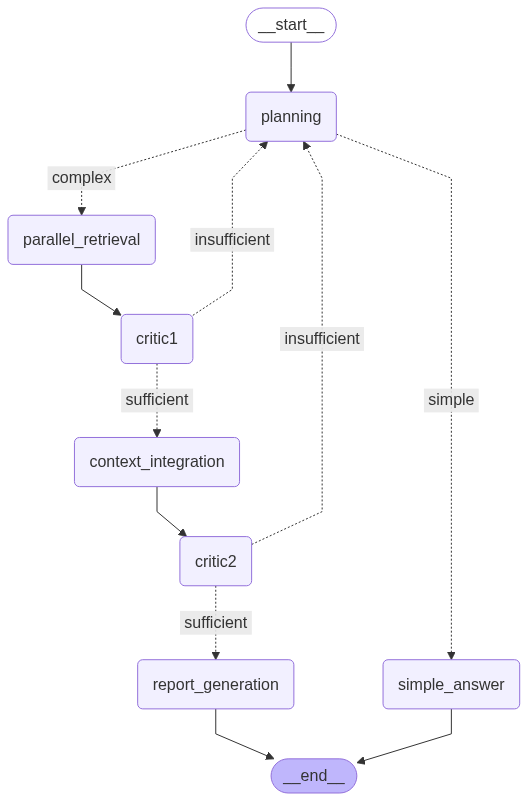

In [32]:
workflow_instance = RAGWorkflow()
app = workflow_instance._create_workflow()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## RAG System Workflow Diagram (Graphviz)

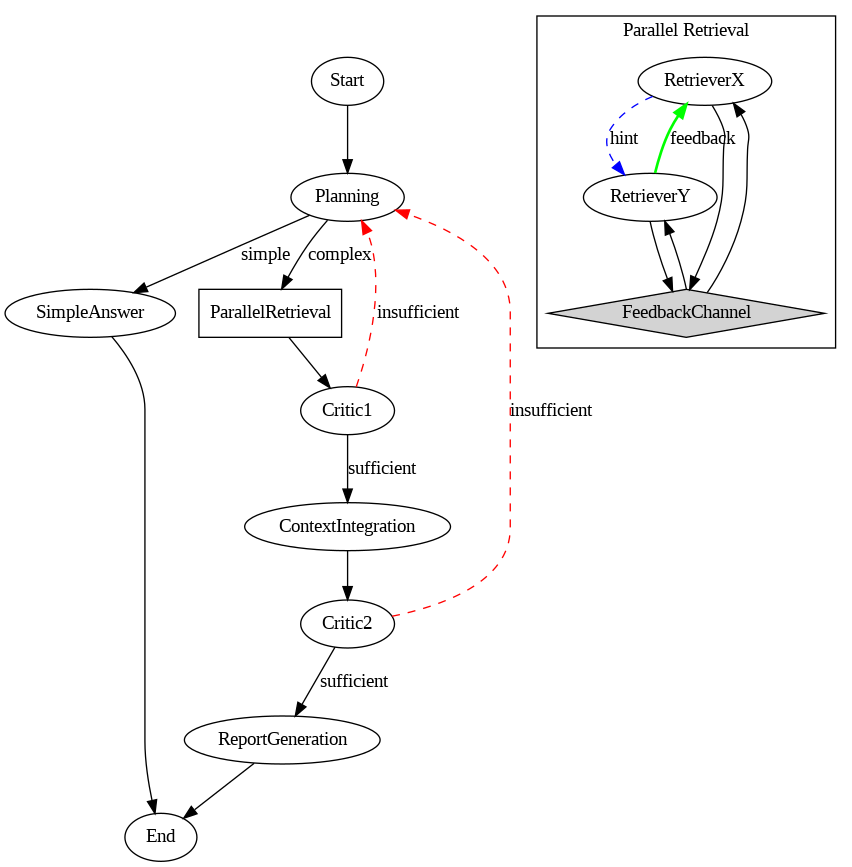

In [33]:
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph('RAG_Workflow', filename='rag_workflow', format='png')

# Main Node
dot.node('Start', shape='ellipse')
dot.node('Planning')
dot.node('SimpleAnswer')
dot.node('ParallelRetrieval', shape='box')
dot.node('Critic1')
dot.node('ContextIntegration')
dot.node('Critic2')
dot.node('ReportGeneration')
dot.node('End', shape='ellipse')

# Main Edge
dot.edge('Start', 'Planning')
dot.edge('Planning', 'SimpleAnswer', label='simple')
dot.edge('Planning', 'ParallelRetrieval', label='complex')
dot.edge('SimpleAnswer', 'End')
dot.edge('ParallelRetrieval', 'Critic1')

dot.edge('Critic1', 'Planning', label='insufficient', color='red', style='dashed')
dot.edge('Critic1', 'ContextIntegration', label='sufficient')
dot.edge('ContextIntegration', 'Critic2')
dot.edge('Critic2', 'Planning', label='insufficient', color='red', style='dashed')
dot.edge('Critic2', 'ReportGeneration', label='sufficient')
dot.edge('ReportGeneration', 'End')

# Parallel Retrieval 내부 서브그래프
with dot.subgraph(name='cluster_parallel') as c:
    c.attr(label='Parallel Retrieval')

    c.node('RetrieverX')
    c.node('RetrieverY')
    c.node('FeedbackChannel', shape='diamond', style='filled', fillcolor='lightgray')

    # 검색 흐름
    c.edge('RetrieverX', 'RetrieverY', label='hint', color='blue', style='dashed')
    c.edge('RetrieverY', 'RetrieverX', label='feedback', color='green', penwidth='2')

    # Feedback Channel
    c.edge('RetrieverX', 'FeedbackChannel')
    c.edge('FeedbackChannel', 'RetrieverY')
    c.edge('RetrieverY', 'FeedbackChannel')
    c.edge('FeedbackChannel', 'RetrieverX')

# 출력 랜더링
dot.render('rag_workflow', format='png')

display(Image(filename='rag_workflow.png'))

# 추가 보완 필요 사항
1. critic -> planning 구조로 변경 고려
 * 현재 critic -> retriever 구조(속도 측면에서 빠름, 하지만 일관된 방향성을 지니게 됨)
 * 실제로 두 구조의 성능 비교 후 큰 차이가 있다면 구조 변경 필요
2.	프롬프트 엔지니어링 강화
 * Agent별 역할 최적화
 * 컨텍스트 통합, 피드백, 평가 프롬프트 개선
 * 일관된 스타일 및 출력 포맷 유지
3.	실제 데이터베이스 연결
 * Vector DB (ElasticSearch)
 * Graph DB (Neo4j)
 * RDB (Postgres)
4.	Retriever Feedback 구조 안정화 및 성능 검증
 * 피드백 루프의 타당성 검증
 * 정보 보완 효과 실험 (피드백 전/후 검색 품질 비교)
 * 현재 max_feedback = 2, 실험적 검증을 통해 수정 필요
 * 오늘 보니 구조 이해를 잘못해서 수정이 필요할 듯 함
5. Planning Agent 수정 및 보완
 * 현재 복잡 쿼리로 판단될 경우 모든 database를 전부 사용하는 것으로 구현함
 * 각 DB의 구체적인 특징 도출 후, 해당 특징에 따라 필요한 DB만 사용하는 것으로 수정할 필요 있음
6. 외부 API 연결 및 실시간 웹서칭 구현
7. 랭킹 구현 필요
8. Memory & History 관리
